In [2]:
# Standard Libraries
import os
import sys
import warnings
from datetime import datetime
from time import time
import unicodedata

# Data Manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from os import listdir
from joblib import dump
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from typing import Tuple
import time
# Détermine si vous êtes sur Google Colab
is_colab = 'google.colab' in sys.modules

# Détermine si vous êtes sur Kaggle
is_kaggle = '/kaggle' in os.getcwd()

# Chemin par défaut
path = None

if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/Python/OCRP/Projet07/data/credit-default-risk'
    output_dir = '/content/drive/MyDrive/Python/OCRP/Projet07/working/graphs'
    os.makedirs(output_dir, exist_ok=True)
    print("\nTu es sur Google Colab")
elif is_kaggle:
    path = "/kaggle/input/credit-risk"
    output_dir = '/kaggle/working/graphs'
    os.makedirs(output_dir, exist_ok=True)
    print("\nTu es sur Kaggle")
else:
    path = "~/Documents/Python/OCR/Projet07/data/credit-risk"
    output_dir = "~/Documents/Python/OCR/Projet07/working/graphs"
    os.makedirs(output_dir, exist_ok=True)
    print("\nTu es en local")

# Utilisez le chemin d'accès sélectionné pour accéder à vos données
if path is not None:
    print("Chemin d'accès aux données:", path)
else:
    print("Impossible de déterminer l'environnement.")
# Chemin d'accès aux données
save_path = "/content/drive/MyDrive/Python/OCRP/Projet07/working/ouput_data"


Mounted at /content/drive

Tu es sur Google Colab
Chemin d'accès aux données: /content/drive/MyDrive/Python/OCRP/Projet07/data/credit-default-risk


In [90]:
# Fonction qui renvoie les valeurs manquantes
def missing_info_sorted(data, column_names=None, get_row=False, row_name=None):
    """
    Renvoie le tableau du nombre de valeurs manquantes par colonne,
    leur facteur de remplissage en pourcentage, et trie les résultats par taux de valeurs manquantes décroissant.

    Args:
        data (pd.DataFrame): Le DataFrame contenant les données.
        column_names (list, optional): Liste des noms de colonnes spécifiques pour lesquelles obtenir les informations.
                                       Si None, toutes les colonnes seront prises en compte. Default is None.
        get_row (bool, optional): Indique si on souhaite obtenir les informations pour une colonne spécifique.
                                  Si True, il faut spécifier row_name. Default is False.
        row_name (str, optional): Le nom de la colonne spécifique pour laquelle obtenir les informations.
                                  Requise si get_row est True. Default is None.

    Returns:
        pd.DataFrame: Le tableau contenant les informations sur les valeurs manquantes et le facteur de remplissage pour chaque colonne.
                      Trié par taux de valeurs manquantes décroissant.
                      Si get_row est True, renvoie uniquement les informations pour la colonne spécifiée par row_name.
    """
    if column_names is None:
        column_names = data.columns

    missing_df = pd.DataFrame(column_names, columns=['nom_colonne'])
    missing_df['nbr_val_manquantes'] = data[column_names].isna().sum().values
    missing_df['facteur_remplissage'] = (1 - (missing_df['nbr_val_manquantes'] / len(data))) * 100

    # Filtrer pour afficher uniquement les colonnes avec des valeurs manquantes
    missing_df = missing_df[missing_df['nbr_val_manquantes'] > 0]

    # Trier par nombre de valeurs manquantes décroissant
    missing_df = missing_df.sort_values(by='nbr_val_manquantes', ascending=False).reset_index(drop=True)

    if get_row:
        if row_name is not None:
            result = missing_df[missing_df['nom_colonne'] == row_name]
            return result
        else:
            raise ValueError("row_name doit être spécifié lorsque get_row est True.")

    return missing_df

# Fonction pour trouver les colonnes avec des valeurs infinies
def find_columns_with_infinite_values(df):
    result = pd.DataFrame()

    # Sélectionner les colonnes numériques
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Trouver les colonnes avec des valeurs infinies positives
    inf_pos_cols = numeric_cols[df[numeric_cols].apply(np.isinf).any()]

    # Trouver les colonnes avec des valeurs infinies négatives
    inf_neg_cols = numeric_cols[df[numeric_cols].apply(lambda x: (x == -float('inf')).any())]

    # Ajouter les colonnes avec des valeurs infinies positives au DataFrame de résultat
    for col in inf_pos_cols:
        inf_pos_rows = np.isinf(df[col]).sum()
        result = pd.concat([result, pd.DataFrame({'colonne': [col], 'inf_count_positive': [inf_pos_rows], 'inf_count_negative': [0]})], ignore_index=True)

    # Ajouter les colonnes avec des valeurs infinies négatives au DataFrame de résultat
    for col in inf_neg_cols:
        inf_neg_rows = (df[col] == -float('inf')).sum()
        if col in result['colonne'].values:
            result.loc[result['colonne'] == col, 'inf_count_negative'] = inf_neg_rows
        else:
            result = pd.concat([result, pd.DataFrame({'colonne': [col], 'inf_count_positive': [0], 'inf_count_negative': [inf_neg_rows]})], ignore_index=True)

    return result

# Fonction pour supprimer les colonnes avec un pourcentage de valeurs manquantes supérieur à un seuil spécifié
def remove_columns_with_high_missing_values(df: pd.DataFrame, threshold: float) -> Tuple[pd.DataFrame, pd.Index]:
    """
    Supprime les colonnes du DataFrame qui ont un pourcentage de valeurs manquantes supérieur au seuil spécifié.

    Args:
    - df (pd.DataFrame): Le DataFrame à nettoyer.
    - threshold (float): Le seuil de pourcentage de valeurs manquantes au-dessus duquel les colonnes seront supprimées.

    Returns:
    - pd.DataFrame: Le DataFrame après suppression des colonnes avec trop de valeurs manquantes.
    """
    def list_nan_columns(df):
        return [i for i in df.columns if df[i].isnull().any()]

    nan_colonnes = list_nan_columns(df)
    print(f'Nombre de colonnes avec NaN values : {len(nan_colonnes)}')

    # Afficher le nombre de colonnes avant suppression
    print("Nombre de colonnes avant suppression des valeurs manquantes:", df.shape[1])

    # Calculer la proportion de valeurs manquantes par colonne
    missing_percentage = df.isnull().mean()

    # Identifier les colonnes avec un pourcentage de valeurs manquantes au-dessus du seuil
    cols_to_drop = missing_percentage[missing_percentage > threshold].index
    print("Nombre de colones à supprimer",len(cols_to_drop))
    print(cols_to_drop)
    # Supprimer les colonnes identifiées
    df_reduced = df.drop(columns=cols_to_drop)
    print(f"Nombre de colonnes après suppression des colonnes avec plus de {threshold} % de valeurs manquantes: {df_reduced.shape[1]}")
    return df_reduced, cols_to_drop

# Fonction pour trouver les colonnes qui ont une seule valeur unique
def find_columns_with_single_unique_value(df: pd.DataFrame) -> list:
    """Retourne les noms des colonnes qui ont une seule valeur unique"""
    unique_vals = df.nunique()
    return unique_vals[unique_vals == 1].index.to_list()

def find_columns_with_zero_variance(df: pd.DataFrame) -> list:
    """Retourne les noms des colonnes qui ont une variance nulle"""
    std_dev = df.std()
    return std_dev[std_dev == 0].index.to_list()

In [91]:
pd.set_option('display.max_columns', None)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 200)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

In [ ]:
#%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [ ]:
#%cd /content/drive/MyDrive/Python/OCRP/Projet07/working/ouput_data/

/content/drive/MyDrive/Python/OCRP/Projet07/working/ouput_data


Starting main()
Current working directory: /content
Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 28s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 35s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 18s
Installments payments df shape: (339587, 26)
Process installments payments - done in 50s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 25s
Combined data save to : combined_data_2024-08-17_18-10-12.csv
Combined data saved to: /content/drive/MyDrive/Python/OCRP/Projet07/working/data
Train DataFrame shape: (307507, 798)
Test DataFrame shape: (48744, 798)
Unique values in target column: [1. 0.]
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
Fold  1 AUC : 0.787023
Fold  2 AUC : 0.788864
Fold  3 AUC : 0.792619
Fold  4 AUC : 0.793012
Fold  5 AUC : 0.792614
Fold  6 AUC : 0.795930
Fold  7 AUC : 0.7

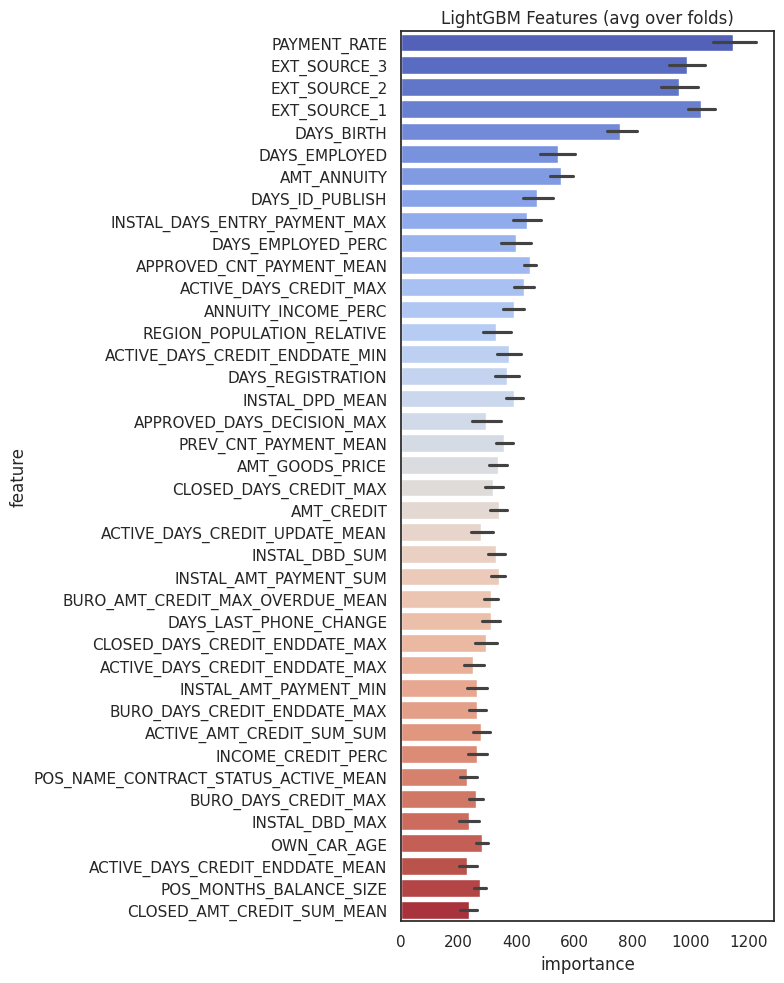

In [ ]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables.
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)
import os
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
import re
from datetime import datetime
import pickle
from joblib import dump, load
from pathlib import Path
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# Define the path variable
path = '/content/drive/MyDrive/Python/OCRP/Projet07/data/credit-default-risk'

def make_dir(folder):
    """
    Créez le dossier s'il n'existe pas déjà
    """
    if not os.path.exists(folder):
        os.makedirs(folder)

# Fonction pour enregistrer le fichier de soumission
def save_submission(submission, submission_file_name):
    """
    Enregistre la soumission dans un fichier CSV
    """
    submission.to_csv(submission_file_name, index=False)
    print(f"File saved as {submission_file_name}")
    return submission_file_name

def get_timestamped_filename(base_name, extension):
    now = datetime.now()
    timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"{base_name}_{timestamp}.{extension}"
    return filename

# Fonction pour créer et changer de répertoire de travail
def create_and_change_working_directory(base_directory):
    # Générer un nom de répertoire unique basé sur la date et l'heure
    timestamp = datetime.now().strftime("%d-%m_%H-%M-%S")
    working_directory = os.path.join(base_directory, f"output_{timestamp}")

    # Créer le répertoire s'il n'existe pas déjà
    make_dir(working_directory)

    # Changer le répertoire courant pour le nouveau répertoire de travail
    os.chdir(working_directory)

    return working_directory


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(f'{path}/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(f'{path}/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))

    df = pd.concat([df,test_df]).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(f'{path}/bureau.csv', nrows = num_rows)
    bb = pd.read_csv(f'{path}/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)

    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)


    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(f'{path}/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(f'{path}/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)


    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(f'{path}/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(f'{path}/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):

    working_directory = os.getcwd()

    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]

    print("Train DataFrame shape:", train_df.shape)
    print("Test DataFrame shape:", test_df.shape)

    # Nettoyer les noms de colonnes
    def clean_column_names(df):
        # Remplacer les espaces par des underscores
        df.columns = [col.replace(' ', '_') for col in df.columns]

        # Remplacer les caractères non alphanumériques par des underscores et convertir en majuscules
        df.columns = [re.sub('[^A-Za-z0-9_]+', '_', col.upper()) for col in df.columns]

        # Remplacer les doubles underscores par un seul underscore
        df.columns = [col.replace('__', '_') for col in df.columns]

        return df

    def impute_missing_values(df):
        imputer_num = SimpleImputer(strategy='mean')
        imputer_cat = SimpleImputer(strategy='most_frequent')

        # Séparer les colonnes numériques et catégorielles
        num_cols = df.select_dtypes(include=[np.number]).columns
        cat_cols = df.select_dtypes(exclude=[np.number]).columns

        # Imputer les valeurs manquantes
        df[num_cols] = imputer_num.fit_transform(df[num_cols])
        df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

        return df

    train_df = clean_column_names(train_df)
    test_df = clean_column_names(test_df)

    #print("Train columns:", train_df.columns)
    #print("Test columns:", test_df.columns)

    print("Unique values in target column:", train_df['TARGET'].unique())

    # Convertir toutes les colonnes de type 'object' en 'float' ou 'int'
    for col in train_df.select_dtypes(include=['object']).columns:
        train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    models = []

    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV', 'INDEX', 'index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]


        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbosity=-1,
            early_stopping_rounds= 200
        )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
            eval_metric= 'auc')

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

        models.append(clf)

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

    # Nommer le fichier de soumission
    submission_file = get_timestamped_filename('submission_file', 'csv')

    filepath = Path('/content/drive/MyDrive/Python/OCRP/Projet07/working/submision')

    make_dir(filepath)
    # Chemin complet du fichier de soumission
    submission_filepath = filepath / submission_file

    # Enregistrer les prédictions
    print("Save Submission file name:", submission_file)
    # Write submission file and plot feature importance
    #if not debug:
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_filepath, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df, models[-1]

# Display/plot feature importance
def display_importances(feature_importance_df_):
    lgbm_importances_png = get_timestamped_filename('lgbm_importances', 'png')
    filepath = Path('/content/drive/MyDrive/Python/OCRP/Projet07/working/graphs')
    make_dir(filepath)
    # Chemin complet du fichier des plots png
    lgbm_importances_path = filepath / lgbm_importances_png

    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False),palette="coolwarm")
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(lgbm_importances_path)


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    # Sauvegarder le DataFrame combiné
    filepath = Path('/content/drive/MyDrive/Python/OCRP/Projet07/working/data')
    make_dir(filepath)
    combined_data_file = get_timestamped_filename('combined_data', 'csv')
    # Chemin complet du fichier de soumission
    combined_data_path = filepath / combined_data_file

    print("Combined data save to :", combined_data_file)
    df.to_csv(combined_data_path, index=False)
    print("Combined data saved to:", filepath)

    with timer("Run LightGBM with kfold"):
        feat_importance, clf = kfold_lightgbm(df, num_folds= 10, stratified= True, debug= debug)

    with timer("Change drectory"):
        # Créer le répertoire de travail s'il n'existe pas déjà
        base_directory = "/content/drive/MyDrive/Python/OCRP/Projet07/working/data"
        working_directory = create_and_change_working_directory(base_directory)
        print("Current working directory:", os.getcwd())

        # Changer le répertoire de travail
        #os.chdir(working_directory)
        #print("Current working directory:", os.getcwd())

        # Sauvegarder les importances des caractéristiques
        feature_importance_file = get_timestamped_filename('feature_importance', 'csv')
        feat_importance.to_csv(feature_importance_file, index=False)
        print("Feature importance saved to:", feature_importance_file)

        # Sauvegarder le modèle LGBM
        model_file_pkl = get_timestamped_filename('lightgbm_model', 'pkl')
        model_file_joblib = get_timestamped_filename('lightgbm_model', 'joblib')
        with open(os.path.join(working_directory, model_file_pkl), 'wb') as f:
            pickle.dump(clf, f)
        print("LightGBM model saved to:", model_file_pkl)

        # Sauvegarder le modèle LightGBM
        dump(clf, os.path.join(working_directory, model_file_joblib))
        print("LightGBM model saved to:", model_file_joblib)

    return feat_importance , clf , df

# Appeler main() et capturer les résultats
if __name__ == "__main__":
    print("Starting main()")
    print("Current working directory:", os.getcwd())
    with timer("Full model run"):
        feat_importance, clf, df = main()
    print("Main function completed.")

In [ ]:
feat_importance.shape

(7950, 3)

In [ ]:
print("Columns in feature_importance_df:", feat_importance.columns)
print("Columns in df:", df.columns)


Columns in feature_importance_df: Index(['feature', 'importance', 'fold'], dtype='object')
Columns in df: Index(['index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=798)


In [ ]:
feat_importance[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:30]

,importance
feature,
PAYMENT_RATE,1146.30
EXT_SOURCE_1,1035.70
EXT_SOURCE_3,987.60
EXT_SOURCE_2,961.70
DAYS_BIRTH,757.00
AMT_ANNUITY,553.60
DAYS_EMPLOYED,541.20
DAYS_ID_PUBLISH,471.30
APPROVED_CNT_PAYMENT_MEAN,444.70


In [ ]:
agg_importance = feat_importance.groupby('feature')['importance'].mean().reset_index()
# Trier les caractéristiques par importance moyenne
agg_importance = agg_importance.sort_values(by='importance', ascending=False)
# Sélectionner les top 50 caractéristiques
top_features = agg_importance.head(100)['feature'].tolist()


In [ ]:
def clean_column_names(df):
    # Remplacer les espaces par des underscores
    df.columns = [col.replace(' ', '_') for col in df.columns]

    # Remplacer les caractères non alphanumériques par des underscores et convertir en majuscules
    df.columns = [re.sub('[^A-Za-z0-9_]+', '_', col.upper()) for col in df.columns]

    # Remplacer les doubles underscores par un seul underscore
    df.columns = [col.replace('__', '_') for col in df.columns]

    return df

# Appliquer la fonction de nettoyage aux noms de colonnes du DataFrame original
df = clean_column_names(df)
# Filtrer les caractéristiques dans le DataFrame d'origine
df_filtered = df[top_features]
# Sauvegarder les caractéristiques importantes
top_features_path = '/content/drive/MyDrive/Python/OCRP/Projet07/working/data/top_features.csv'
df_filtered.to_csv(top_features_path, index=False)
#pd.DataFrame(top_features, columns=['feature']).to_csv(top_features_path, index=False)


In [ ]:
df.shape

(356251, 798)

In [ ]:
import os

# Chemin vers le répertoire contenant les fichiers CSV
path = '/content/drive/MyDrive/Python/OCRP/Projet07/working/data'

# Charger le DataFrame avec Dask
df = pd.read_csv(os.path.join(path, 'combined_data_2024-08-17_18-10-12.csv'))

# Calculer la forme
shape = df.shape
print("Shape of the DataFrame:", shape)


Shape of the DataFrame: (356251, 798)


In [3]:
import os
import pandas as pd

def calc_rank_feature(df: pd.DataFrame, modelname='model') -> pd.DataFrame:
    ret = df.groupby(['feature'])['importance'].mean(
    ).sort_values(ascending=False).reset_index()
    ret = ret.rename_axis('rank').reset_index()
    ret['rank'] = ret['rank'].astype(int)
    ret['model'] = modelname
    return ret


def load_latest_file(directory, prefix=''):
    # Liste tous les fichiers dans le répertoire
    files = os.listdir(directory)

    # Filtrer les fichiers par préfixe ou motif spécifique (optionnel)
    files = [f for f in files if f.startswith(prefix) and f.endswith('.csv')]  # Exemple pour les fichiers CSV

    # Trier les fichiers par date de modification (du plus récent au plus ancien)
    files.sort(key=lambda x: os.path.getmtime(os.path.join(directory, x)), reverse=True)

    # Sélectionner le premier fichier (le plus récent)
    latest_file = files[0] if files else None

    if latest_file:
        # Charger le fichier CSV dans un DataFrame pandas
        file_path = os.path.join(directory, latest_file)
        df = pd.read_csv(file_path)
        return df
    else:
        print(f"Aucun fichier trouvé dans le répertoire {directory} avec le préfixe {prefix}.")
        return None


# Exemple d'utilisation
directory = '/content/drive/MyDrive/Python/OCRP/Projet07/working/data/output_17-08_19-16-25'
prefix = 'feature_importance_'  # Préfixe des fichiers à rechercher

feat_importance_lgbm = load_latest_file(directory, prefix)
if feat_importance_lgbm is not None:
    lgbm = calc_rank_feature(feat_importance_lgbm, 'lgbm')
lgbm.head(10)

,rank,feature,importance,model
0,0,PAYMENT_RATE,1146.3,lgbm
1,1,EXT_SOURCE_1,1035.7,lgbm
2,2,EXT_SOURCE_3,987.6,lgbm
3,3,EXT_SOURCE_2,961.7,lgbm
4,4,DAYS_BIRTH,757.0,lgbm
5,5,AMT_ANNUITY,553.6,lgbm
6,6,DAYS_EMPLOYED,541.2,lgbm
7,7,DAYS_ID_PUBLISH,471.3,lgbm
8,8,APPROVED_CNT_PAYMENT_MEAN,444.7,lgbm
9,9,INSTAL_DAYS_ENTRY_PAYMENT_MAX,435.9,lgbm


In [4]:
feat_importance_lgbm['feature'].nunique()

795

In [5]:
import re

# Appliquer la fonction de nettoyage aux noms de colonnes du DataFrame original
df_cleaned = df.copy()
clean_column_names(df_cleaned)

# Obtenir les noms de colonnes nettoyés
df_columns_cleaned = set(df_cleaned.columns)

# Colonnes de feat_importance_lgbm
feat_importance_columns = set(feat_importance_lgbm['feature'])

# Vérifier les colonnes manquantes après nettoyage
missing_features_cleaned = df_columns_cleaned - feat_importance_columns

print("Nombre de caractéristiques manquantes après nettoyage:", len(missing_features_cleaned))
print("Caractéristiques manquantes après nettoyage:", missing_features_cleaned)


NameError: name 'df' is not defined

In [ ]:
# Exclure les colonnes spécifiques après nettoyage
df_columns_cleaned_excluded = df_columns_cleaned - {'SK_ID_CURR', 'TARGET','INDEX'}

# Re-vérifier les colonnes manquantes après exclusion
missing_features_cleaned_excluded = df_columns_cleaned_excluded - feat_importance_columns

print("Nombre de caractéristiques manquantes après exclusion:", len(missing_features_cleaned_excluded))
print("Caractéristiques manquantes après exclusion:", missing_features_cleaned_excluded)


Nombre de caractéristiques manquantes après exclusion: 0
Caractéristiques manquantes après exclusion: set()


In [ ]:
# Retirer 'TARGET', 'index', et 'SK_ID_CURR' des colonnes d'origine
df_cleaned = df_cleaned.drop(columns=['TARGET', 'INDEX', 'SK_ID_CURR'])

# Colonnes de feat_importance_lgbm déjà nettoyées
feat_importance_columns = set(feat_importance_lgbm['feature'])

# Vérifier que les colonnes restantes sont bien alignées
remaining_features = set(df_cleaned.columns)
missing_features_final = remaining_features - feat_importance_columns

print("Nombre de caractéristiques restantes:", len(remaining_features))
print("Nombre de caractéristiques manquantes après nettoyage final:", len(missing_features_final))
print("Caractéristiques manquantes après nettoyage final:", missing_features_final)


Nombre de caractéristiques restantes: 795
Nombre de caractéristiques manquantes après nettoyage final: 0
Caractéristiques manquantes après nettoyage final: set()


In [ ]:
import os
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
import re
from datetime import datetime
import pickle
from joblib import dump, load
from pathlib import Path
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import dask.dataframe as dd
import pandas as pd
import os
import re

def clean_column_names(df):
    # Remplacer les espaces par des underscores
    df.columns = [col.replace(' ', '_') for col in df.columns]

    # Remplacer les caractères non alphanumériques par des underscores et convertir en majuscules
    df.columns = [re.sub('[^A-Za-z0-9_]+', '_', col.upper()) for col in df.columns]

    # Remplacer les doubles underscores par un seul underscore
    df.columns = [col.replace('__', '_') for col in df.columns]

    return df

# Chemin vers le répertoire contenant les fichiers CSV
path_feat = '/content/drive/MyDrive/Python/OCRP/Projet07/working/data/output_17-08_19-16-25'
feat_importance_lgbm = pd.read_csv(os.path.join(path_feat, 'feature_importance_2024-08-17_19-16-25.csv'))

# Agréger les importances par moyenne
feat_importance_aggregated = feat_importance_lgbm.groupby('feature')['importance'].mean().reset_index()

# Trier les caractéristiques par importance moyenne
feat_importance_aggregated = feat_importance_aggregated.sort_values(by='importance', ascending=False)

# Calculer l'importance cumulative
feat_importance_aggregated['cumulative_importance'] = (
    feat_importance_aggregated['importance'].cumsum() / feat_importance_aggregated['importance'].sum()
).astype('float32')

# Conserver les caractéristiques jusqu'à un seuil de 95% d'importance cumulative
threshold = 0.95
important_features = feat_importance_aggregated[feat_importance_aggregated['cumulative_importance'] <= threshold]['feature'].tolist()

# Charger le DataFrame nettoyé
path = '/content/drive/MyDrive/Python/OCRP/Projet07/working/data'
df = pd.read_csv(os.path.join(path, 'combined_data_2024-08-17_18-10-12.csv'))

df_cleaned = df.copy()
df_cleaned = clean_column_names(df_cleaned)

# Filtrer les colonnes du DataFrame original
df_important = df_cleaned[important_features]

# Calculer la forme du DataFrame filtré
n_rows_important = df_important.shape[0]
n_cols_important = df_important.shape[1]

print("Nombre de caractéristiques importantes conservées après agrégation :", len(important_features))
print("Shape of the filtered DataFrame after aggregation: ({}, {})".format(n_rows_important, n_cols_important))


Nombre de caractéristiques importantes conservées après agrégation : 379
Shape of the filtered DataFrame after aggregation: (356251, 379)


In [ ]:
missing_features = [feat for feat in important_features if feat not in df_cleaned.columns]
if missing_features:
    print(f"Les caractéristiques suivantes sont manquantes dans le DataFrame nettoyé : {missing_features}")
else:
    print("Toutes les caractéristiques importantes sont présentes dans le DataFrame nettoyé.")


Toutes les caractéristiques importantes sont présentes dans le DataFrame nettoyé.


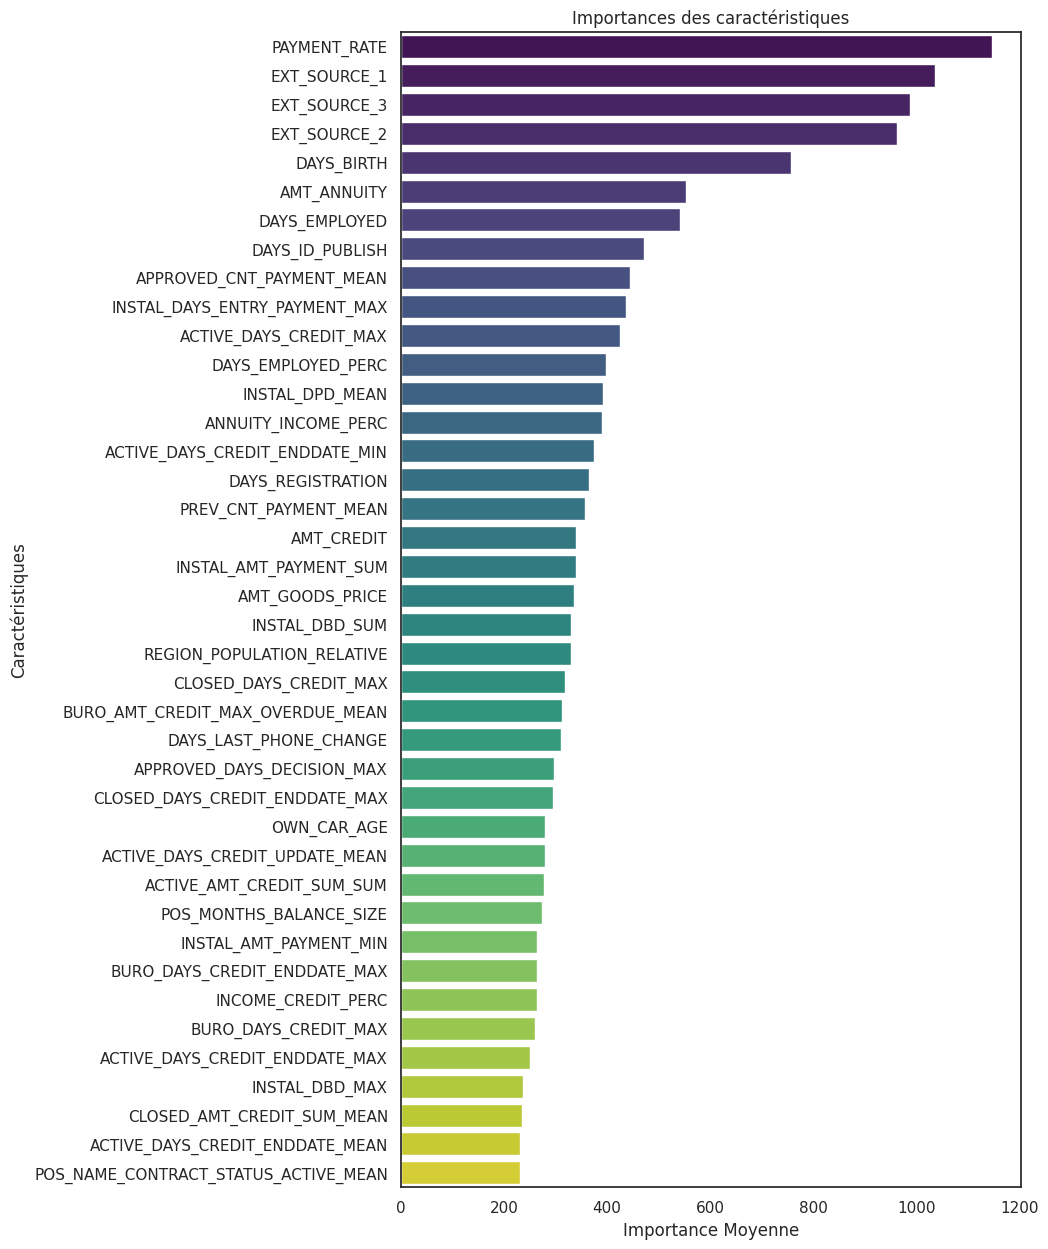

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualiser les importances des caractéristiques
plt.figure(figsize=(8, 15))
sns.barplot(
    y='feature',
    x='importance',
    data=feat_importance_aggregated.head(40),
    palette="viridis"
)
plt.title('Importances des caractéristiques')
plt.xlabel('Importance Moyenne')
plt.ylabel('Caractéristiques')
plt.show()


In [ ]:
# Liste des colonnes à exclure (index, cible et autres non caractéristiques)
columns_to_exclude = ['INDEX', 'SK_ID_CURR', 'TARGET']

# Filtrer les colonnes restantes en excluant celles non pertinentes
remaining_features = [col for col in df_cleaned.columns if col not in important_features and col not in columns_to_exclude]

# Nombre unique de caractéristiques
num_important_features = len(set(important_features))
num_remaining_features = len(set(remaining_features))

print(f"Nombre de caractéristiques uniques importantes : {num_important_features}")
print(f"Nombre de caractéristiques uniques restantes : {num_remaining_features}")

# Vérifier quelques caractéristiques importantes conservées
print("Quelques caractéristiques importantes conservées:")
print(important_features[:10])

# Vérifier les caractéristiques restantes non conservées
print("Quelques caractéristiques restantes non conservées:")
print(remaining_features[:10])


Nombre de caractéristiques uniques importantes : 379
Nombre de caractéristiques uniques restantes : 416
Quelques caractéristiques importantes conservées:
['PAYMENT_RATE', 'EXT_SOURCE_1', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'APPROVED_CNT_PAYMENT_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX']
Quelques caractéristiques restantes non conservées:
['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REG_REGION_NOT_LIVE_REGION']


In [ ]:
# Vérifier l'absence de chevauchement
overlap = set(important_features) & set(remaining_features)
print(f"Nombre de caractéristiques qui se chevauchent : {len(overlap)}")


Nombre de caractéristiques qui se chevauchent : 0


In [ ]:
# Ajouter 'SK_ID_CURR' et 'TARGET' à la liste des caractéristiques importantes
important_features.extend(['SK_ID_CURR', 'TARGET'])

# Filtrer le DataFrame pour ne conserver que les colonnes importantes
filtered_df = df_cleaned[important_features]
filtered_df.shape

# Sauvegarder le DataFrame filtré dans un nouveau fichier CSV
output_path = '/content/drive/MyDrive/Python/OCRP/Projet07/working/data/important_features_extend_data.csv'
filtered_df.to_csv(output_path, index=False)

print(f"Le DataFrame filtré a été sauvegardé dans : {output_path}")

Le DataFrame filtré a été sauvegardé dans : /content/drive/MyDrive/Python/OCRP/Projet07/working/data/important_features_extend_data.csv


In [ ]:
# Ajouter une colonne pour indiquer si la caractéristique est importante ou restante
def label_features(df, important_features, remaining_features):
    """Ajouter une colonne indiquant le type de chaque caractéristique."""
    df['feature_type'] = df['feature'].apply(
        lambda x: 'important' if x in important_features else ('remaining' if x in remaining_features else 'other')
    )
    return df

# Ajouter les étiquettes
lgbm_labeled = label_features(lgbm, important_features, remaining_features)

# Sauvegarder le DataFrame avec les étiquettes ajoutées
output_path = '/content/feature_importance_labeled.csv'
output_path = '/content/drive/MyDrive/Python/OCRP/Projet07/working/data/feature_importance_labeled.csv'

lgbm_labeled.to_csv(output_path, index=False)

print(f"Le DataFrame avec les étiquettes a été sauvegardé dans : {output_path}")

# Afficher les premières lignes du DataFrame pour vérification
print(lgbm_labeled.head())

Le DataFrame avec les étiquettes a été sauvegardé dans : /content/drive/MyDrive/Python/OCRP/Projet07/working/data/feature_importance_labeled.csv
   rank       feature  importance model feature_type
0     0  PAYMENT_RATE     1146.30  lgbm    important
1     1  EXT_SOURCE_1     1035.70  lgbm    important
2     2  EXT_SOURCE_3      987.60  lgbm    important
3     3  EXT_SOURCE_2      961.70  lgbm    important
4     4    DAYS_BIRTH      757.00  lgbm    important


In [ ]:
len(remaining_features)

416

## Data Pre-processing Pipeline

In [ ]:
# Obtenir les colonnes avec des valeurs infinies
infinite_values_info = find_columns_with_infinite_values(df_cleaned)

print(infinite_values_info)

                        colonne  inf_count_positive  inf_count_negative
0      PREV_APP_CREDIT_PERC_MAX                   1                   0
1     PREV_APP_CREDIT_PERC_MEAN                   1                   0
2   REFUSED_APP_CREDIT_PERC_MAX                   1                   0
3  REFUSED_APP_CREDIT_PERC_MEAN                   1                   0
4       INSTAL_PAYMENT_PERC_MAX                  19                   0
5      INSTAL_PAYMENT_PERC_MEAN                  19                   0
6       INSTAL_PAYMENT_PERC_SUM                  19                   0


In [ ]:
columns_with_single_value = find_columns_with_single_unique_value(df_cleaned)
print("Colonnes une seule valeur unique",columns_with_single_value)
print("Nombre de colonnes",len(columns_with_single_value))

#columns_with_zero_variance = find_columns_with_zero_variance(df)
#print("Colonnes avec une variance nulle",columns_with_zero_variance)

Colonnes une seule valeur unique ['BURO_CREDIT_ACTIVE_NAN_MEAN', 'BURO_CREDIT_CURRENCY_NAN_MEAN', 'BURO_CREDIT_TYPE_NAN_MEAN', 'BURO_STATUS_NAN_MEAN_MEAN', 'PREV_NAME_CONTRACT_TYPE_NAN_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_NAN_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_NAN_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_NAN_MEAN', 'PREV_NAME_CONTRACT_STATUS_NAN_MEAN', 'PREV_NAME_PAYMENT_TYPE_NAN_MEAN', 'PREV_CODE_REJECT_REASON_NAN_MEAN', 'PREV_NAME_CLIENT_TYPE_NAN_MEAN', 'PREV_NAME_GOODS_CATEGORY_NAN_MEAN', 'PREV_NAME_PORTFOLIO_NAN_MEAN', 'PREV_NAME_PRODUCT_TYPE_NAN_MEAN', 'PREV_CHANNEL_TYPE_NAN_MEAN', 'PREV_NAME_SELLER_INDUSTRY_NAN_MEAN', 'PREV_NAME_YIELD_GROUP_NAN_MEAN', 'POS_NAME_CONTRACT_STATUS_NAN_MEAN', 'CC_NAME_CONTRACT_STATUS_APPROVED_MIN', 'CC_NAME_CONTRACT_STATUS_REFUSED_MIN', 'CC_NAME_CONTRACT_STATUS_SENT_PROPOSAL_MIN', 'CC_NAME_CONTRACT_STATUS_NAN_MIN', 'CC_NAME_CONTRACT_STATUS_NAN_MAX', 'CC_NAME_CONTRACT_STATUS_NAN_MEAN', 'CC_NAME_CONTRACT_STATUS_NAN_SUM', 'CC_NAME_CONTRACT_STATUS_NAN

In [ ]:
results = []

# Itérer sur les colonnes avec une seule valeur unique
for column in columns_with_single_value:
    unique_value = df_cleaned[column].unique()[0]  # Récupérer la valeur unique
    count = df_cleaned[column].value_counts().iloc[0]  # Compter les occurrences de la valeur unique
    results.append((column, count, unique_value))  # Ajouter les résultats à la liste

# Convertir la liste en DataFrame
unique_df = pd.DataFrame(results, columns=['Variable', 'Count', 'Unique Value'])

# Afficher le résultat
unique_df

,Variable,Count,Unique Value
0,BURO_CREDIT_ACTIVE_NAN_MEAN,305807,0.00
1,BURO_CREDIT_CURRENCY_NAN_MEAN,305807,0.00
2,BURO_CREDIT_TYPE_NAN_MEAN,305807,0.00
3,BURO_STATUS_NAN_MEAN_MEAN,134542,0.00
4,PREV_NAME_CONTRACT_TYPE_NAN_MEAN,338853,0.00
5,PREV_WEEKDAY_APPR_PROCESS_START_NAN_MEAN,338853,0.00
6,PREV_FLAG_LAST_APPL_PER_CONTRACT_NAN_MEAN,338853,0.00
7,PREV_NAME_CASH_LOAN_PURPOSE_NAN_MEAN,338853,0.00
8,PREV_NAME_CONTRACT_STATUS_NAN_MEAN,338853,0.00
9,PREV_NAME_PAYMENT_TYPE_NAN_MEAN,338853,0.00


In [ ]:
missing_info_sorted(df_cleaned, column_names=None, get_row=False, row_name=None).head(10)

,nom_colonne,nbr_val_manquantes,facteur_remplissage
0,REFUSED_RATE_DOWN_PAYMENT_MAX,303648,14.77
1,REFUSED_RATE_DOWN_PAYMENT_MIN,303648,14.77
2,REFUSED_RATE_DOWN_PAYMENT_MEAN,303648,14.77
3,REFUSED_AMT_DOWN_PAYMENT_MIN,303648,14.77
4,REFUSED_AMT_DOWN_PAYMENT_MAX,303648,14.77
5,REFUSED_AMT_DOWN_PAYMENT_MEAN,303648,14.77
6,REFUSED_APP_CREDIT_PERC_VAR,298034,16.34
7,CC_AMT_PAYMENT_CURRENT_VAR,284649,20.10
8,CC_CNT_DRAWINGS_POS_CURRENT_VAR,284559,20.12
9,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,284559,20.12


In [ ]:
import pandas as pd
import numpy as np

def optimize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Optimise le DataFrame en supprimant les colonnes avec des valeurs infinies,
    des valeurs uniques ou une variance nulle"""

    print("Shape du DataFrame avant suppression:", df.shape)
    # Remplacer les valeurs infinies par NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Identifier les colonnes avec une seule valeur unique
    columns_with_single_value = find_columns_with_single_unique_value(df)
    #print("Colonnes une seule valeur unique",columns_with_single_value)
    # Identifier les colonnes avec une variance nulle
    columns_with_zero_variance = find_columns_with_zero_variance(df)
    #print("Colonnes avec une variance nulle",columns_with_zero_variance)
    # Combiner les colonnes à supprimer
    columns_to_drop = set(columns_with_single_value).union(columns_with_zero_variance)

    # Supprimer ces colonnes du DataFrame
    df_filtered = df.drop(columns=columns_to_drop)

    print(f"Nombre de colonnes supprimées: {len(columns_to_drop)}")
    print(f"Shape du DataFrame après suppression: {df_filtered.shape}")

    return df_filtered

# Appliquer la fonction d'optimisation
df_cleaned = df.copy()
df_cleaned = clean_column_names(df_cleaned)


In [ ]:
from contextlib import contextmanager
import time

# Définir le contexte de gestion du temps

def data_preprocessing_steps(df):
    # Traitement des valeurs infinies et à varainces nulles ou uniques
    with timer("Remplacement des valeurs infinies par NaN et suppession des colonnes à variances nulles ou uniques"):
        df = optimize_dataframe(df)
    # Supprimer les colonnes avec plus de 70% de valeurs manquantes
    with timer("Suppression des colonnes avec plus de 70% de valeurs manquantes"):
        df,cols_to_drop = remove_columns_with_high_missing_values(df,0.7)
        print("Nombre de colonnes supprimées:",len(cols_to_drop))
        print("Shape du DataFrame après suppression:",df.shape)

    return df,cols_to_drop,columns_with_single_value

# Appliquer les étapes de prétraitement
df_cleaned ,cols_to_drop,columns_with_single_value = data_preprocessing_steps(df_cleaned)

Shape du DataFrame avant suppression: (356251, 798)
Nombre de colonnes supprimées: 27
Shape du DataFrame après suppression: (356251, 771)
Remplacement des valeurs infinies par NaN et suppession des colonnes à variances nulles ou uniques - done in 17s
Nombre de colonnes avec NaN values : 590
Nombre de colonnes avant suppression des valeurs manquantes: 771
Nombre de colones à supprimer 144
Index(['ACTIVE_AMT_ANNUITY_MAX', 'ACTIVE_AMT_ANNUITY_MEAN',
       'CLOSED_AMT_ANNUITY_MAX', 'CLOSED_AMT_ANNUITY_MEAN',
       'REFUSED_APP_CREDIT_PERC_VAR', 'REFUSED_AMT_DOWN_PAYMENT_MIN',
       'REFUSED_AMT_DOWN_PAYMENT_MAX', 'REFUSED_AMT_DOWN_PAYMENT_MEAN',
       'REFUSED_RATE_DOWN_PAYMENT_MIN', 'REFUSED_RATE_DOWN_PAYMENT_MAX',
       ...
       'CC_NAME_CONTRACT_STATUS_SENT_PROPOSAL_MAX',
       'CC_NAME_CONTRACT_STATUS_SENT_PROPOSAL_MEAN',
       'CC_NAME_CONTRACT_STATUS_SENT_PROPOSAL_SUM',
       'CC_NAME_CONTRACT_STATUS_SENT_PROPOSAL_VAR',
       'CC_NAME_CONTRACT_STATUS_SIGNED_MIN',
       'C

In [ ]:
#df_cleaned.to_csv('/kaggle/working/df_cleaned.csv', index=False)



#### Étapes de Pré-Sélection

1. **Sélection des Caractéristiques avec Différentes Méthodes**

   - **Pearson Correlation**
   - **Chi-2**
   - **RFE (Recursive Feature Elimination)**
   - **Logistic Regression L1**
   - **Random Forest**
   - **LightGBM**

2. **Combinaison et Sélection des Caractéristiques Communes**

   - **Combiner les caractéristiques sélectionnées par chaque méthode.**
   - **Identifier les caractéristiques communes à plusieurs méthodes.**

3. **Filtrage Final des Caractéristiques**

   - **Sélectionner les 100 meilleures caractéristiques communes.**
   - **Construire un ensemble de données réduit avec ces caractéristiques.**

Distribution de la cible (en pourcentage):
TARGET
0.00   91.93
1.00    8.07
Name: proportion, dtype: float64


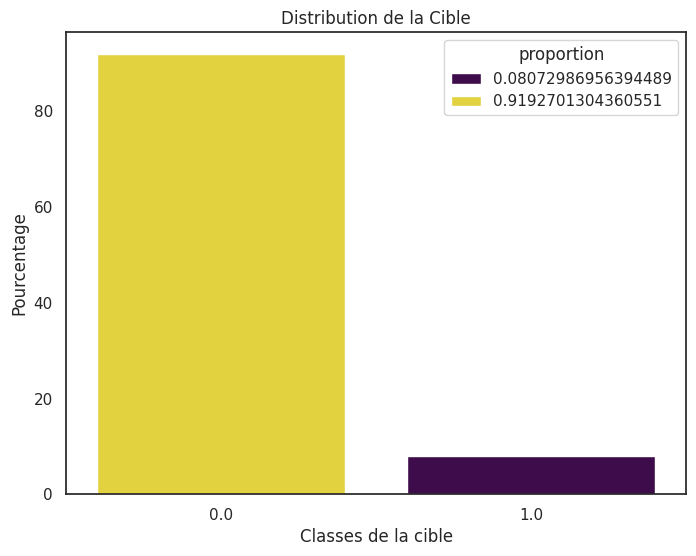

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_target_distribution(df, target_column='TARGET'):
    # Calculer la distribution de la cible
    target_counts = df[target_column].value_counts(normalize=True)

    # Afficher la distribution
    print("Distribution de la cible (en pourcentage):")
    print(target_counts * 100)

    # Visualiser la distribution
    plt.figure(figsize=(8, 6))
    sns.barplot(x=target_counts.index, y=target_counts.values * 100, hue=target_counts, palette='viridis')
    plt.xlabel('Classes de la cible')
    plt.ylabel('Pourcentage')
    plt.title('Distribution de la Cible')
    plt.show()

    return target_counts

# Exemple d'utilisation
target_distribution = analyze_target_distribution(df_cleaned, 'TARGET')


### Préparation de X,y

Je vais combiner la stratification et le random undersampling pour simplifier  
mes analyses et me donner la possibilité de travailler avec des échantillons.

In [ ]:
!pip install imblearn

In [ ]:
pip install --upgrade pip

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

def stratified_undersample(df, target_column='TARGET', id_column='SK_ID_CURR', sample_frac=0.3, random_state=None):
    """
    Effectue un échantillonnage stratifié suivi d'un random undersampling pour équilibrer les classes.

    Parameters:
    df (pd.DataFrame): Le DataFrame d'origine contenant les données.
    target_column (str): Le nom de la colonne cible (par défaut 'TARGET').
    id_column (str): Le nom de la colonne identifiant (par défaut 'SK_ID_CURR').
    sample_frac (float): La fraction d'échantillonnage pour la stratification (par défaut 0.3).
    random_state (int): Seed pour assurer la reproductibilité (par défaut None).

    Returns:
    X_resampled (pd.DataFrame): Le DataFrame des features après undersampling.
    y_resampled (pd.Series): La série des cibles après undersampling.
    """

    # Stratified Sampling
    df_sample1 = df[df[target_column] == 1].sample(frac=sample_frac, replace=False, random_state=random_state)
    df_sample0 = df[df[target_column] == 0].sample(frac=sample_frac, replace=False, random_state=random_state)

    df_sampled = pd.concat([df_sample1, df_sample0], axis=0).sort_values(by=id_column).reset_index(drop=True)

    # Prepare features and target
    X_sampled = df_sampled.drop(columns=[id_column, target_column])
    y_sampled = df_sampled[target_column]

    # Random Undersampling
    rus = RandomUnderSampler(random_state=random_state)
    X_resampled, y_resampled = rus.fit_resample(X_sampled, y_sampled)

    return X_resampled, y_resampled

# Mon merge cleaned ...  # Votre DataFrame initial
X_resampled, y_resampled = stratified_undersample(df_cleaned, sample_frac=1.0, random_state=42)
print(f'Taille de X après undersampling: {X_resampled.shape}')
print(f'Taille de y après undersampling: {y_resampled.shape}')


Taille de X après undersampling: (49650, 625)
Taille de y après undersampling: (49650,)


### Imputation des valeurs manquantes

- Je vais utilisé une stratégie d'imputation différentes :
- la médiane pour les variables numériques.
- Et intégrer ces étapes dans notre fonction pour s'assurer que les données sont prétraitées de manière cohérente.

In [ ]:
from sklearn.impute import SimpleImputer

def preprocess_data(df):
    # Copie du DataFrame pour éviter de modifier l'original
    df_copy = df.copy()

    # Séparation des colonnes catégoriques et numériques
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns.tolist()
    numerical_cols = df_copy.select_dtypes(include=[np.number]).columns.tolist()

    # Taille du DataFrame
    nrow, nvar = df_copy.shape
    print(f'Le jeu de données contient {nrow} lignes et {nvar} variables.')
    print('Nombre de variables catégoriques :', len(categorical_cols))
    print('Nombre de variables numériques :', len(numerical_cols))

    # Imputation des valeurs manquantes
    if numerical_cols:
        imputer_num = SimpleImputer(strategy='median')
        df_copy[numerical_cols] = imputer_num.fit_transform(df_copy[numerical_cols])

    return df_copy, categorical_cols, numerical_cols

df_cleaned_copy = df_cleaned.sample(frac=0.1, random_state=42).copy()
# Exemple d'utilisation
df_processed, categorical_cols, numerical_cols = preprocess_data(df_cleaned_copy)


Le jeu de données contient 35625 lignes et 627 variables.
Nombre de variables catégoriques : 133
Nombre de variables numériques : 494


### OneHotEncoding des catégoriques

In [ ]:
import pandas as pd

def apply_one_hot_encoding(df, categorical_cols):
    """
    Applique le One-Hot Encoding aux colonnes catégoriques du DataFrame.

    Parameters:
    - df: DataFrame à transformer
    - categorical_cols: Liste des colonnes catégoriques à encoder

    Returns:
    - DataFrame avec les colonnes catégoriques encodées
    """
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    return df_encoded

def filter_binary_columns(df):
    """
    Filtre les colonnes binaires du DataFrame pour ne conserver qu'une colonne par ensemble de colonnes binaires.

    Parameters:
    - df: DataFrame à filtrer

    Returns:
    - DataFrame avec les colonnes binaires filtrées
    """
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]
    columns_to_keep = {}
    for col in binary_cols:
        prefix = '_'.join(col.split('_')[:-1])
        if prefix not in columns_to_keep:
            columns_to_keep[prefix] = col

    cols_to_keep = list(columns_to_keep.values())
    df_filtered = df[cols_to_keep]

    return df_filtered

# Exemple d'utilisation après l'imputation
df_processed, categorical_cols, numerical_cols = preprocess_data(df_cleaned_copy)

# Appliquer le One-Hot Encoding
df_encoded = apply_one_hot_encoding(df_processed, categorical_cols)

# Filtrer les colonnes binaires
df_encoded_filtered = filter_binary_columns(df_encoded)

print("DataFrame après One-Hot Encoding :")
print(f"Taille du DataFrame après encodage : {df_encoded.shape}")
print(f"Taille du DataFrame après filtrage des colonnes binaires : {df_encoded_filtered.shape}")


Le jeu de données contient 35625 lignes et 627 variables.
Nombre de variables catégoriques : 133
Nombre de variables numériques : 494
DataFrame après One-Hot Encoding :
Taille du DataFrame après encodage : (35625, 624)
Taille du DataFrame après filtrage des colonnes binaires : (35625, 149)


### 1.1 Pearson Correlation

    Normalization: no
    Impute missing values: yes


- La sélection de caractéristiques basée sur la corrélation entre chaque caractéristique et la cible (y)  


In [ ]:
import pandas as pd
import numpy as np
import time
from contextlib import contextmanager
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer


@contextmanager
def timer(name):
    start = time.time()
    yield
    end = time.time()
    print(f'[{name}] done in {end - start:.3f} s')

def select_top_features_by_correlation(X, y, num_features=100):
    """
    Sélectionne les caractéristiques les plus corrélées avec la cible en utilisant la corrélation.

    Parameters:
    - X: DataFrame contenant les caractéristiques.
    - y: Série contenant la cible.
    - num_features: Nombre de caractéristiques à sélectionner basées sur la corrélation.

    Returns:
    - selected_features: Liste des noms des caractéristiques sélectionnées.
    - feature_support: Liste de booléens indiquant si chaque caractéristique est sélectionnée.
    """
    cor_list = []
    feature_names = X.columns.tolist()

    for feature in feature_names:
        if X[feature].std() == 0:
            cor_list.append(0)
        else:
            cor = np.corrcoef(X[feature], y)[0, 1]
            cor_list.append(cor)

    # Remplacer NaN par 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]

    # Sélectionner les caractéristiques avec les plus fortes corrélations
    top_features = np.argsort(np.abs(cor_list))[-num_features:]
    selected_features = X.columns[top_features].tolist()

    # Créer une liste de booléens pour la sélection
    feature_support = [True if feature in selected_features else False for feature in feature_names]

    return selected_features, feature_support

# Mon merge cleaned ...  # Votre DataFrame initial
X_resampled, y_resampled = stratified_undersample(df_cleaned, sample_frac=1.0, random_state=42)
print(f'Taille de X après undersampling: {X_resampled.shape}')
print(f'Taille de y après undersampling: {y_resampled.shape}')

X_filled, X_categorical_cols, X_numerical_cols = preprocess_data(X_resampled)

with timer('Correlation'):
    cor_selected_features, cor_support = select_top_features_by_correlation(X_filled[X_numerical_cols], y_resampled, num_features=100)

print(f"{len(cor_selected_features)} features selected based on correlation")


Taille de X après undersampling: (49650, 625)
Taille de y après undersampling: (49650,)
Le jeu de données contient 49650 lignes et 625 variables.
Nombre de variables catégoriques : 133
Nombre de variables numériques : 492
[Correlation] done in 0.636 s
100 features selected based on correlation


### Sélection des Caractéristiques avec le Chi-2

1.2 Chi-2

    Normalization: MinMaxScaler (values should be bigger than 0)
    Impute missing values: yes

- La méthode Chi-2 est un test statistique utilisé pour évaluer l'association entre chaque caractéristique et la cible, dans le contexte des variables catégorielles.


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

def select_top_features_chi2(X, y, num_features=100):
    """
    Sélectionne les caractéristiques les plus pertinentes en utilisant le test Chi-2.

    Parameters:
    - X: DataFrame contenant les caractéristiques.
    - y: Série contenant la cible.
    - num_features: Nombre de caractéristiques à sélectionner.

    Returns:
    - selected_features: Liste des noms des caractéristiques sélectionnées.
    - feature_support: Liste de booléens indiquant si chaque caractéristique est sélectionnée.
    """
    # Normalisation des données pour Chi-2 (les valeurs doivent être positives)
    X_norm = MinMaxScaler().fit_transform(X)

    # Sélection des meilleures caractéristiques avec Chi-2
    chi_selector = SelectKBest(chi2, k=num_features)
    chi_selector.fit(X_norm, y)

    # Obtenir les caractéristiques sélectionnées
    chi_support = chi_selector.get_support()
    selected_features = X.columns[chi_support].tolist()

    # Créer une liste de booléens pour la sélection
    feature_support = [True if feature in selected_features else False for feature in X.columns]

    return selected_features, feature_support

# Exemple d'utilisation
with timer('Chi-2 Selection'):
    chi_selected_features, chi_support = select_top_features_chi2(X_filled, y_resampled, num_features=100)
print(f"{len(chi_selected_features)} features selected by Chi-2")


[Chi-2 Selection] done in 2.699 s
100 features selected by Chi-2


### Recursive Feature Elimination (RFE)
2. Wrapper

    documentation for RFE: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

    Normalization: depend on the used model; yes for LR  
    Impute missing values: depend on the used model; yes for LR  

- RFE est une méthode de sélection de caractéristiques qui fonctionne en éliminant  
récursivement les caractéristiques les moins importantes. Voici comment cela fonctionne :

   1. Entraînement Initial : Le modèle est entraîné avec toutes les caractéristiques.
   2. Évaluation de l'Importance : Les caractéristiques sont classées par importance en utilisant les coefficients du modèle.
   3. Élimination : Les caractéristiques les moins importantes sont supprimées.
   4. Réentraînement : Le modèle est réentraîné avec les caractéristiques restantes.
   5. Répétition : Les étapes 2 à 4 sont répétées jusqu'à ce que le nombre souhaité de caractéristiques soit atteint.
   
   
- **Feature Selection Précise** : RFE permet de sélectionner les caractéristiques les plus pertinentes pour un modèle spécifique en fonction de leur performance.
- Adaptabilité : Peut être utilisé avec différents modèles (Logistic Regression, Ridge Classifier, etc.) pour répondre à divers besoins.  

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression  # Ou RidgeClassifier pour plus de vitesse
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def select_top_features_rfe(X, y, estimator, num_features=100, step=10):
    """
    Sélectionne les caractéristiques les plus pertinentes en utilisant la méthode RFE.

    Parameters:
    - X: DataFrame contenant les caractéristiques.
    - y: Série contenant la cible.
    - estimator: Modèle à utiliser pour évaluer les caractéristiques.
    - num_features: Nombre de caractéristiques à sélectionner.
    - step: Nombre de caractéristiques à éliminer à chaque étape.

    Returns:
    - selected_features: Liste des noms des caractéristiques sélectionnées.
    - feature_support: Liste de booléens indiquant si chaque caractéristique est sélectionnée.
    """
    # Normaliser les données si nécessaire
    X_scaled = MinMaxScaler().fit_transform(X)

    # Initialiser et entraîner le sélecteur RFE
    rfe_selector = RFE(estimator=estimator, n_features_to_select=num_features, step=step, verbose=5)
    rfe_selector.fit(X_scaled, y)

    # Obtenir les caractéristiques sélectionnées
    rfe_support = rfe_selector.get_support()
    selected_features = X.columns[rfe_support].tolist()

    # Créer une liste de booléens pour la sélection
    feature_support = [True if feature in selected_features else False for feature in X.columns]

    return selected_features, feature_support

# Exemple d'utilisation
with timer('Recursive Feature Elimination (Logistic Regression)'):
    rfe_selected_features, rfe_feature_support = select_top_features_rfe(X_filled, y_resampled,
                                                                         estimator=LogisticRegression(max_iter=100, solver='liblinear'))
print(f"{len(rfe_selected_features)} features selected by RFE")


Fitting estimator with 625 features.
Fitting estimator with 615 features.
Fitting estimator with 605 features.
Fitting estimator with 595 features.
Fitting estimator with 585 features.
Fitting estimator with 575 features.
Fitting estimator with 565 features.
Fitting estimator with 555 features.
Fitting estimator with 545 features.
Fitting estimator with 535 features.
Fitting estimator with 525 features.
Fitting estimator with 515 features.
Fitting estimator with 505 features.
Fitting estimator with 495 features.
Fitting estimator with 485 features.
Fitting estimator with 475 features.
Fitting estimator with 465 features.
Fitting estimator with 455 features.
Fitting estimator with 445 features.
Fitting estimator with 435 features.
Fitting estimator with 425 features.
Fitting estimator with 415 features.
Fitting estimator with 405 features.
Fitting estimator with 395 features.
Fitting estimator with 385 features.
Fitting estimator with 375 features.
Fitting estimator with 365 features.
F

### Embedded Feature Selection

    Normalization: Yes
    Impute missing values: Yes
    
- La méthode Embedded Feature Selection se réfère à l'utilisation des caractéristiques importantes  
déterminées par le modèle lui-même pendant l'entraînement. En d'autres termes,  
l'algorithme de sélection des caractéristiques est intégré dans le processus d'entraînement du modèle.
- Cette approche utilise les poids ou les coefficients du modèle pour sélectionner les caractéristiques les plus importantes.
- Sélection de Caractéristiques avec Logistic Regression (Pénalité L1)

- Logistic Regression avec pénalité L1 est souvent utilisé pour la sélection de caractéristiques,  
car la pénalité L1 (Lasso) tend à réduire les coefficients des caractéristiques non importantes à zéro.
- Cela permet une sélection implicite des caractéristiques importantes.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

def select_features_logistic_regression(X, y, threshold='1.25*median', penalty='l1'):
    """
    Sélectionne les caractéristiques les plus importantes en utilisant Logistic Regression avec une pénalité L1.

    Parameters:
    - X: DataFrame contenant les caractéristiques.
    - y: Série contenant la cible.
    - threshold: Seuil pour sélectionner les caractéristiques.
    - penalty: Type de pénalité ('l1' pour Lasso).

    Returns:
    - selected_features: Liste des noms des caractéristiques sélectionnées.
    - feature_support: Liste de booléens indiquant si chaque caractéristique est sélectionnée.
    """
    # Initialiser le sélecteur avec Logistic Regression et la pénalité L1
    selector = SelectFromModel(LogisticRegression(penalty=penalty, solver='liblinear'), threshold=threshold)

    # Entraîner le sélecteur
    selector.fit(X, y)

    # Obtenir les caractéristiques sélectionnées
    feature_support = selector.get_support()
    selected_features = X.columns[feature_support].tolist()

    return selected_features, feature_support

# Utiliser MinMaxScaler tout en conservant X comme DataFrame
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_filled), columns=X_filled.columns)

# Exemple d'utilisation
with timer('Logistic Regression with L1 penalty'):
    embedded_lr_features, embedded_lr_support = select_features_logistic_regression(X_scaled, y_resampled, threshold='1.25*median')

print(f"{len(embedded_lr_features)} features selected by Logistic Regression (L1)")


[Logistic Regression with L1 penalty] done in 190.535 s
291 features selected by Logistic Regression (L1)


### Sélection de Caractéristiques avec Random Forest

3.2 Random Forest

    Normalization: No
    Impute missing values: Yes

- La sélection de caractéristiques via Random Forest est une méthode efficace pour déterminer  
les caractéristiques importantes en se basant sur l'importance des caractéristiques mesurée par l'algorithme de Random Forest.

- Fonctionnement de la Méthode

Random Forest est un ensemble de nombreux arbres de décision. Lors de l'entraînement,  
chaque arbre évalue l'importance des caractéristiques en fonction de la réduction de   
l'impureté qu'elles apportent (comme la réduction de l'entropie ou de l'indice de Gini).

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

def select_features_random_forest(X, y, max_features=100):
    """
    Sélectionne un nombre fixe de caractéristiques les plus importantes en utilisant Random Forest.

    Parameters:
    - X: DataFrame contenant les caractéristiques.
    - y: Série contenant la cible.
    - max_features: Nombre maximum de caractéristiques à sélectionner.

    Returns:
    - selected_features: Liste des noms des caractéristiques sélectionnées.
    - feature_support: Liste de booléens indiquant si chaque caractéristique est sélectionnée.
    """
    # Initialiser le sélecteur avec Random Forest
    selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=max_features)

    # Entraîner le sélecteur
    with timer('Random Forest'):
        selector.fit(X, y)

    # Obtenir les caractéristiques sélectionnées
    feature_support = selector.get_support()
    selected_features = X.columns[feature_support].tolist()

    return selected_features, feature_support

# Exemple d'utilisation
embedded_rf_features, embedded_rf_support = select_features_random_forest(X_filled, y_resampled, max_features=100)
print(f"{len(embedded_rf_features)} features selected by Random Forest")


[Random Forest] done in 75.848 s
100 features selected by Random Forest


### LightGBM Feature Selection
3.3 LightGBM

Note

    Normalization: No
    Impute missing values: No

- Utiliser LightGBM pour sélectionner des caractéristiques importantes en utilisant la méthode SelectFromModel
- Mais avec les paramètres trouvés par le Bayesian optimization: on verra si les features corespondent à celles trouvées la première fois.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
import pandas as pd

def select_features_lightgbm(X: pd.DataFrame, y: pd.Series, threshold: str = '1.25*median', max_features: int = None, verbose: bool = True):
    """
    Sélectionne les caractéristiques importantes en utilisant LightGBM.

    Args:
    - X (pd.DataFrame): Les données d'entrée (features).
    - y (pd.Series): La variable cible (labels).
    - threshold (str, optional): Le seuil pour la sélection des caractéristiques (par défaut '1.25*median').
    - max_features (int, optional): Le nombre maximum de caractéristiques à sélectionner (si None, utiliser le seuil).
    - verbose (bool, optional): Si True, affiche les résultats (par défaut True).

    Returns:
    - list: Liste des noms des caractéristiques sélectionnées.
    """

    # Initialisation du classifieur LightGBM avec les paramètres spécifiés
    clf = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=32,
        colsample_bytree=0.2,
        reg_alpha=3,
        reg_lambda=1,
        min_split_gain=0.01,
        min_child_weight=40,
        force_row_wise=True,


    )

    # Création de l'objet SelectFromModel
    if max_features is not None:
        embedded_lgb_selector = SelectFromModel(clf, max_features=max_features)
    else:
        embedded_lgb_selector = SelectFromModel(clf, threshold=threshold)

    # Ajustement du modèle
    embedded_lgb_selector.fit(X, y)

    # Obtention des caractéristiques sélectionnées
    support = embedded_lgb_selector.get_support()
    selected_features = X.columns[support].tolist()

    # Affichage des résultats si verbose est True
    if verbose:
        print(f"{len(selected_features)} selected features using LightGBM.")

    return selected_features

# Exemple d'utilisation
with timer('LightGBM Process'):
    embedded_lgb_support = select_features_lightgbm(X_resampled, y_resampled)


[LightGBM] [Info] Number of positive: 24825, number of negative: 24825
[LightGBM] [Info] Total Bins 70644
[LightGBM] [Info] Number of data points in the train set: 49650, number of used features: 603
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
292 selected features using LightGBM.
[LightGBM Process] done in 18.775 s


Résumé des Résultats

    Nombre total de caractéristiques utilisées : 603
    Nombre de caractéristiques sélectionnées : 292
    Temps d'exécution : 27.570 secondes

In [ ]:
import pandas as pd
import numpy as np

def align_support_list(support_list, feature_names, original_feature_names, is_numeric=False):
    """
    Aligne la liste de support pour correspondre aux noms des caractéristiques.

    Args:
    - support_list (list): Liste de supports booléens ou indices des caractéristiques sélectionnées.
    - feature_names (list): Liste des noms des caractéristiques.
    - original_feature_names (list): Liste originale des noms de caractéristiques avant filtrage.
    - is_numeric (bool): Indique si le support_list est basé uniquement sur les caractéristiques numériques.

    Returns:
    - list: Liste de support alignée.
    """
    # Créer une liste de support initiale avec des False
    aligned_support = [False] * len(feature_names)

    if is_numeric:
        # Si le support est basé sur des caractéristiques numériques seulement
        feature_mapping = {name: idx for idx, name in enumerate(original_feature_names)}
        for idx in range(len(support_list)):
            feature_name = original_feature_names[idx]
            if feature_name in feature_mapping:
                aligned_support[feature_mapping[feature_name]] = support_list[idx]
    else:
        # Si le support est basé sur toutes les caractéristiques
        for idx in support_list:
            if idx < len(feature_names):
                aligned_support[idx] = True

    return aligned_support

# Exemple d'alignement des supports

# Liste originale des caractéristiques
original_feature_names = X_resampled.columns.tolist()

# Alignement pour les caractéristiques numériques
cor_support_aligned = align_support_list(cor_support, original_feature_names, X_filled[X_numerical_cols].columns.tolist(), is_numeric=True)

# Alignement pour les caractéristiques complètes
embedded_lgb_support_aligned = align_support_list(range(len(embedded_lgb_support)), original_feature_names, original_feature_names, is_numeric=False)



In [ ]:
#original_feature_names = X_resampled.columns.tolist()

print("Longueur de feature_names:", len(original_feature_names))
print("Longueur de cor_support:", len(cor_support))
print("Longueur de chi_support:", len(chi_support))
print("Longueur de rfe_feature_support:", len(rfe_feature_support))
print("Longueur de embedded_lr_support:", len(embedded_lr_support))
print("Longueur de embedded_rf_support:", len(embedded_rf_support))
print("Longueur de embedded_lgb_support:", len(embedded_lgb_support))


Longueur de feature_names: 625
Longueur de cor_support: 492
Longueur de chi_support: 625
Longueur de rfe_feature_support: 625
Longueur de embedded_lr_support: 625
Longueur de embedded_rf_support: 625
Longueur de embedded_lgb_support: 292


### Résumer des Sélections de Caractéristiques

In [ ]:
import pandas as pd
import numpy as np

# Fonction de résumé
def summarize_feature_selection(feature_names, cor_support, chi_support, rfe_feature_support,
                                embedded_lr_support, embedded_rf_support, embedded_lgb_support):
    feature_selection_df = pd.DataFrame({
        'Feature': feature_names,
        'Pearson': cor_support,
        'Chi-2': chi_support,
        'RFE': rfe_feature_support,
        'Logistics': embedded_lr_support,
        'Random Forest': embedded_rf_support,
        'LightGBM': embedded_lgb_support
    })

    feature_selection_df['Total'] = feature_selection_df[['Pearson', 'Chi-2', 'RFE', 'Logistics', 'Random Forest', 'LightGBM']].sum(axis=1)
    feature_selection_df = feature_selection_df.sort_values(['Total', 'Feature'], ascending=[False, True])
    feature_selection_df.index = range(1, len(feature_selection_df) + 1)

    return feature_selection_df.head(100)

# Tableau
summary_df = summarize_feature_selection(
    original_feature_names,
    cor_support_aligned,
    chi_support,
    rfe_feature_support,
    embedded_lr_support,
    embedded_rf_support,
    embedded_lgb_support_aligned
)

summary_df


,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,EXT_SOURCE_1,True,True,True,True,True,True,6
2,EXT_SOURCE_2,True,True,True,True,True,True,6
3,EXT_SOURCE_3,True,True,True,True,True,True,6
4,AMT_CREDIT,True,False,True,True,True,True,5
5,AMT_GOODS_PRICE,True,False,True,True,True,True,5
6,ANNUITY_INCOME_PERC,True,False,True,True,True,True,5
7,BURO_DAYS_CREDIT_ENDDATE_MEAN,True,False,True,True,True,True,5
8,BURO_DAYS_CREDIT_MIN,True,True,False,True,True,True,5
9,BURO_DAYS_CREDIT_UPDATE_MEAN,True,False,True,True,True,True,5
10,DAYS_BIRTH,True,True,False,True,True,True,5


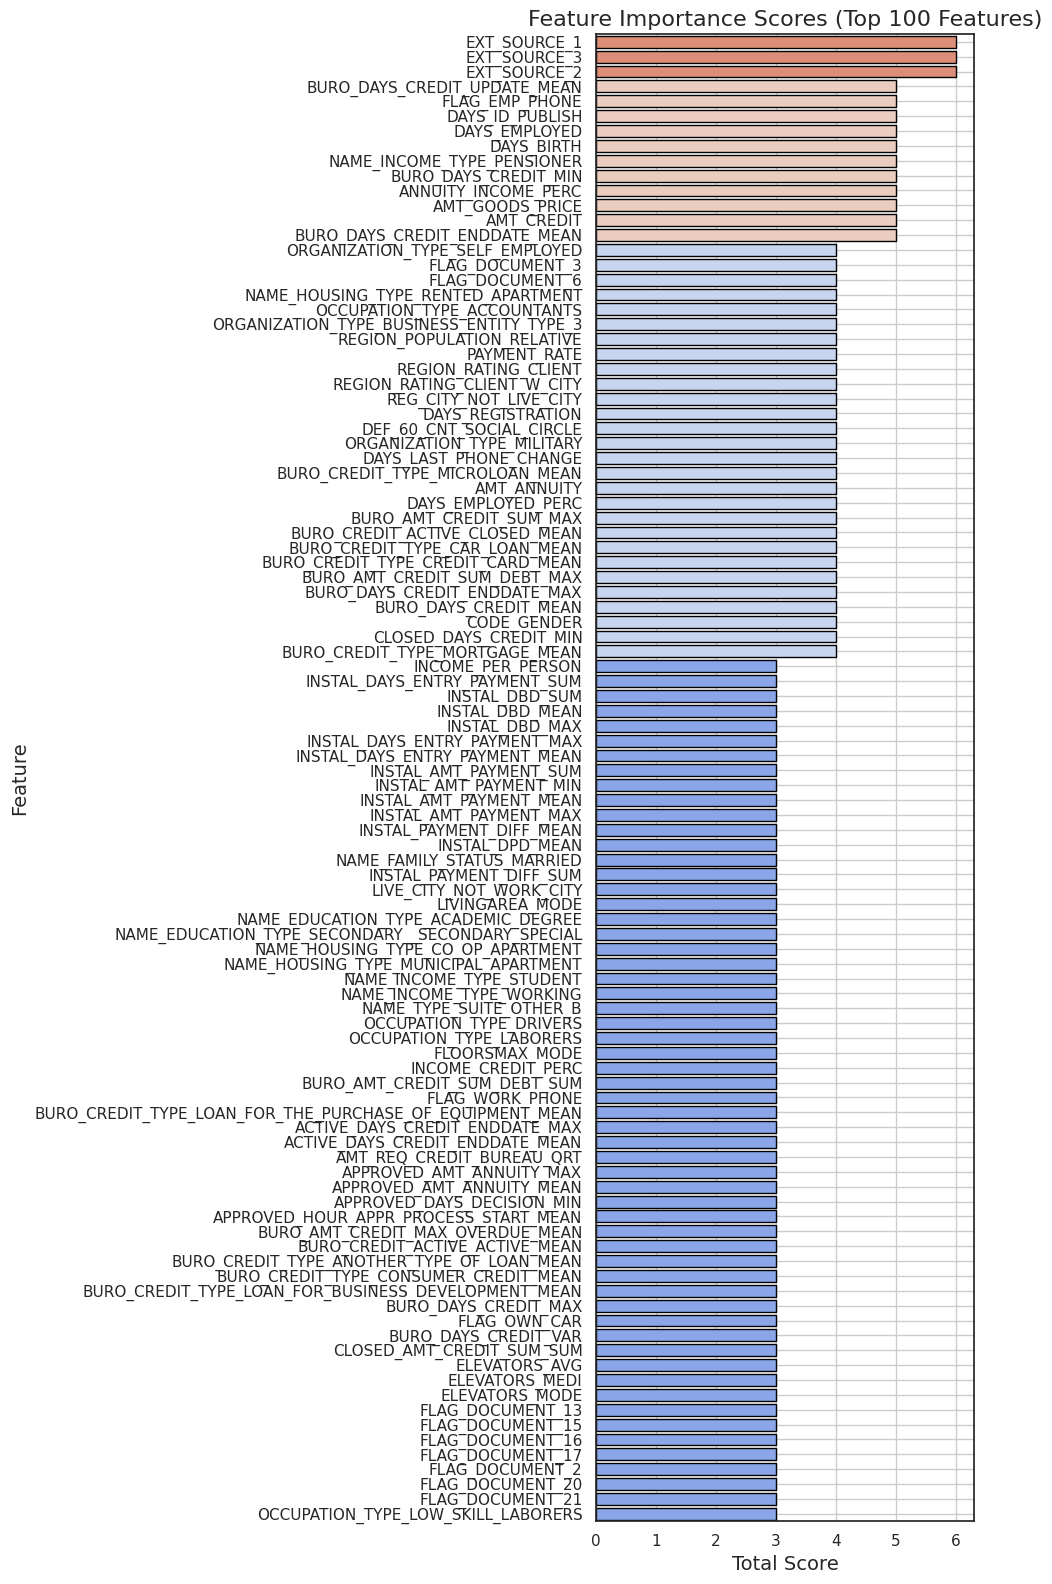

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assurez-vous que 'Total' est de type int
summary_df['Total'] = summary_df['Total'].astype(int)

# Trier les données par la colonne 'Total' pour afficher les features les plus importantes en haut
summary_df_sorted = summary_df.sort_values(by='Total', ascending=False)

# Définir la palette de couleurs discrète en fonction du nombre unique de 'Total'
palette = sns.color_palette("coolwarm", n_colors=4)  # tab10 est une palette discrète avec 10 couleurs distinctes

# Créer un dictionnaire pour mapper chaque valeur de 'Total' à une couleur
total_unique = sorted(summary_df_sorted['Total'].unique())
color_mapping = {total: palette[i] for i, total in enumerate(total_unique)}

# Appliquer le mapping de couleurs aux barres
bar_colors = summary_df_sorted['Total'].map(color_mapping).tolist()  # Convertir en liste pour sns.barplot

# Définir la taille de la figure
plt.figure(figsize=(10, 16))

# Créer le barplot
sns.barplot(
    y='Feature',  # Mettre les features sur l'axe des y pour un affichage de haut en bas
    x='Total',    # Le score total sur l'axe des x
    data=summary_df_sorted,  # Utiliser les données triées
    palette=bar_colors,  # Appliquer les couleurs mappées
    edgecolor='black'    # Bordures des barres en noir pour plus de clarté
)

# Ajouter les labels et le titre
plt.xlabel('Total Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance Scores (Top 100 Features)', fontsize=16)
plt.grid(True)  # Ajouter une grille pour améliorer la lisibilité
plt.tight_layout()  # Ajuster les marges de la figure

# Afficher le plot
plt.show()


### Identifier les 100 Meilleures Caractéristiques

In [ ]:
import pandas as pd

# Obtenir les 100 meilleures caractéristiques du DataFrame summary_df
top_100_features = summary_df.head(100)['Feature'].tolist()

# Vérifier si toutes les 100 meilleures caractéristiques sont présentes dans X_resampled
missing_features = [feature for feature in top_100_features if feature not in X_resampled.columns]
if missing_features:
    print(f"Attention : Les caractéristiques suivantes sont manquantes dans X_resampled : {missing_features}")

# Filtrer X_resampled pour ne garder que les 100 meilleures caractéristiques
X_reshape = X_resampled[top_100_features]

print(f"Taille de X après sélection des 100 meilleures caractéristiques : {X_reshape.shape}")

Taille de X après sélection des 100 meilleures caractéristiques : (49650, 100)


In [ ]:
# Obtenir les 100 meilleures caractéristiques du DataFrame summary_df
top_100_features = summary_df.head(100)['Feature'].tolist()

In [ ]:
# Sauvegarde finale dans un fichier pickle si nécessaire
import pickle

variables_data_to_save = {
    'X_resampled': X_resampled,
    'X_filled': X_filled,
    'X_scaled': X_scaled,
    'df_cleaned': df_cleaned if 'df_cleaned' in locals() else None
}

# Sauvegarde des variables dans un fichier pickle
with open('/content/drive/MyDrive/Python/OCRP/Projet07/working/output/variables_backup_final.pkl', 'wb') as file:
    pickle.dump(variables_data_to_save, file)

print("Variables sauvegardées avec succès.")

Variables sauvegardées avec succès.


In [ ]:
# Sauvegarder X_filtered si nécessaire
import pickle

# Ajouter X_filtered au dictionnaire pour sauvegarde
variables_finale_to_save = {
    'X_filled': X_filled,
    'y_resampled': y_resampled,
    'cor_support': cor_support,
    'X_resampled': X_resampled,
    'summary_df': summary_df,
    'chi_selected_features': chi_selected_features,
    'rfe_selected_features': rfe_selected_features,
    'embedded_lr_features': embedded_lr_features,
    'X_scaled': X_scaled if 'X_scaled' in locals() else None,
    'embedded_rf_features': embedded_rf_features,
    'embedded_lgb_support': embedded_lgb_support,
    'feature_selection_df': feature_selection_df if 'feature_selection_df' in locals() else summary_df,
    'X_reshape': X_reshape
}

# Sauvegarde des variables dans un fichier pickle
with open('/content/drive/MyDrive/Python/OCRP/Projet07/working/output/variables_backup.pkl', 'wb') as file:
    pickle.dump(variables_finale_to_save, file)

print("Variables sauvegardées avec succès.")

Variables sauvegardées avec succès.


In [ ]:
import pandas as pd

# Extraire les 100 meilleures caractéristiques
top_100_features = summary_df.head(100)['Feature'].tolist()

# Filtrer df_cleaned pour ne conserver que les 100 meilleures caractéristiques
df_cleaned_filtered = df_cleaned[top_100_features]
top_100_features.extend(['TARGET', 'SK_ID_CURR'])

# Filtrer df_cleaned pour ne conserver que les 100 meilleures caractéristiques ainsi que 'TARGET' et 'SK_ID_CURR'
df_cleaned_filtered = df_cleaned[top_100_features]


# Sauvegarder le DataFrame filtré dans un fichier CSV
df_cleaned_filtered.to_csv('/content/drive/MyDrive/Python/OCRP/Projet07/working/output/df_cleaned_filtered_102_plus_features.csv', index=False)

print("DataFrame avec les 100 meilleures caractéristiques sauvegardé avec succès.")


DataFrame avec les 100 meilleures caractéristiques sauvegardé avec succès.


In [ ]:
# Fonction pour filtrer les caractéristiques et afficher les manquantes
def check_features_exist(df, features):
    # Liste des caractéristiques manquantes
    missing_features = [feature for feature in features if feature not in df.columns]
    if missing_features:
        print(f"Attention : Les caractéristiques suivantes sont manquantes dans le DataFrame : {missing_features}")
    # Liste des caractéristiques présentes
    existing_features = [feature for feature in features if feature in df.columns]
    return df[existing_features]

# Filtrer les DataFrames en utilisant la liste mise à jour des caractéristiques
df_cleaned = check_features_exist(df_cleaned, top_100_features)
X_resampled = check_features_exist(X_resampled, top_100_features)
X_filled = check_features_exist(X_filled, top_100_features)
X_scaled = check_features_exist(X_scaled, top_100_features)

# Vérifier les tailles pour s'assurer que le filtrage s'est bien passé
print(f"Taille de df_cleaned après sélection des meilleures caractéristiques : {df_cleaned.shape}")
print(f"Taille de X_resampled après sélection des meilleures caractéristiques : {X_resampled.shape}")
print(f"Taille de X_filled après sélection des meilleures caractéristiques : {X_filled.shape}")
print(f"Taille de X_scaled après sélection des meilleures caractéristiques : {X_scaled.shape}")


Attention : Les caractéristiques suivantes sont manquantes dans le DataFrame : ['TARGET', 'SK_ID_CURR']
Attention : Les caractéristiques suivantes sont manquantes dans le DataFrame : ['TARGET', 'SK_ID_CURR']
Attention : Les caractéristiques suivantes sont manquantes dans le DataFrame : ['TARGET', 'SK_ID_CURR']
Taille de df_cleaned après sélection des meilleures caractéristiques : (356251, 102)
Taille de X_resampled après sélection des meilleures caractéristiques : (49650, 100)
Taille de X_filled après sélection des meilleures caractéristiques : (49650, 100)
Taille de X_scaled après sélection des meilleures caractéristiques : (49650, 100)


In [ ]:
df_cleaned.info(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Data columns (total 102 columns):
 #    Column                                                    Dtype  
---   ------                                                    -----  
 0    EXT_SOURCE_1                                              float64
 1    EXT_SOURCE_2                                              float64
 2    EXT_SOURCE_3                                              float64
 3    AMT_CREDIT                                                float64
 4    AMT_GOODS_PRICE                                           float64
 5    ANNUITY_INCOME_PERC                                       float64
 6    BURO_DAYS_CREDIT_ENDDATE_MEAN                             float64
 7    BURO_DAYS_CREDIT_MIN                                      float64
 8    BURO_DAYS_CREDIT_UPDATE_MEAN                              float64
 9    DAYS_BIRTH                                                int64  
 10   DAYS_EMPLOYED     

## Chargement

In [6]:
# Lire le fichier CSV pour vérifier
df_cleaned_filtered = pd.read_csv('/content/drive/MyDrive/Python/OCRP/Projet07/working/output/df_cleaned_filtered_102_plus_features.csv')
print(f"Taille du DataFrame des features est : {df_cleaned_filtered.shape}")
lgbm_labeled = pd.read_csv('/content/drive/MyDrive/Python/OCRP/Projet07/working/data/feature_importance_labeled.csv')
print(f"Taille du DataFrame des label est : {lgbm_labeled.shape}")

Taille du DataFrame des features est : (356251, 102)
Taille du DataFrame des label est : (795, 5)


In [7]:
top_100_features = df_cleaned_filtered.columns.tolist()


### Analyse des corrélations des features

In [ ]:
lgbm_labeled[:450]

,rank,feature,importance,model,feature_type
0,0,PAYMENT_RATE,1146.30,lgbm,important
1,1,EXT_SOURCE_1,1035.70,lgbm,important
2,2,EXT_SOURCE_3,987.60,lgbm,important
3,3,EXT_SOURCE_2,961.70,lgbm,important
4,4,DAYS_BIRTH,757.00,lgbm,important
...,...,...,...,...,...
445,445,CC_NAME_CONTRACT_STATUS_ACTIVE_SUM,15.70,lgbm,remaining
446,446,CC_AMT_INST_MIN_REGULARITY_MAX,15.60,lgbm,remaining
447,447,PREV_NAME_SELLER_INDUSTRY_CLOTHING_MEAN,15.60,lgbm,remaining
448,448,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,15.50,lgbm,remaining


In [8]:
import pandas as pd

# Filtrer les caractéristiques importantes
important_features_df = lgbm_labeled[lgbm_labeled['feature_type'] == 'important']

# Trier les caractéristiques par importance décroissante
sorted_important_features_df = important_features_df.sort_values(by='importance', ascending=False)

# Extraire la liste des caractéristiques triées
top_cumulative_lgbm_liste = sorted_important_features_df['feature'].tolist()

print("Liste des caractéristiques importantes triées par importance :")
print(len(top_cumulative_lgbm_liste))


Liste des caractéristiques importantes triées par importance :
379


In [9]:
def find_different_columns(df1, df2):
    """
    Compare les colonnes de deux DataFrames et renvoie une liste des colonnes qui ne sont pas communes.

    Paramètres :
    - df1, df2 : objets pandas.DataFrame
        Les deux DataFrames à comparer.

    Retour :
    - list
        Liste des noms de colonnes qui n'appartiennent pas aux deux DataFrames.
    """
    columns_df1 = set(df1.columns)
    columns_df2 = set(df2.columns)

    # Trouver les colonnes qui n'appartiennent qu'à l'un des deux DataFrames
    unique_columns = list(columns_df1.symmetric_difference(columns_df2))

    return unique_columns


#different_columns = find_different_columns(df_cleaned_building_secondary, df_cleaned_building_primary)
#print(different_columns)

def compare_lists(list1, list2):
    """
    Compare deux listes et renvoie les éléments uniques à chaque liste ainsi que les éléments communs.

    Paramètres :
    - list1, list2 : listes
        Les deux listes à comparer.

    Retour :
    - dict
        Dictionnaire contenant trois listes :
        - 'unique_to_list1' : éléments uniquement dans list1
        - 'unique_to_list2' : éléments uniquement dans list2
        - 'common_elements' : éléments communs aux deux listes
    """
    set1 = set(list1)
    set2 = set(list2)

    unique_to_list1 = list(set1 - set2)
    unique_to_list2 = list(set2 - set1)
    common_elements = list(set1 & set2)

    return {
        'unique_to_list1': unique_to_list1,
        'unique_to_list2': unique_to_list2,
        'common_elements': common_elements
    }

def extract_comparison_lists(comparison_result):
    """
    Extrait les listes du dictionnaire de résultats de comparaison.

    Paramètres :
    - comparison_result : dict
        Dictionnaire contenant les résultats de la comparaison des listes.

    Retour :
    - tuple de listes
        Contient les listes d'éléments uniques à chaque liste et les éléments communs.
    """
    unique_to_list1 = comparison_result.get('unique_to_list1', [])
    unique_to_list2 = comparison_result.get('unique_to_list2', [])
    common_elements = comparison_result.get('common_elements', [])

    return unique_to_list1, unique_to_list2, common_elements

list1 = top_cumulative_lgbm_liste.copy()
list2 = df_cleaned_filtered.columns.tolist().copy()


# Comparer les listes
comparison_result = compare_lists(list1, list2)

# Extraire les listes
unique_to_list1, unique_to_list2, common_elements = extract_comparison_lists(comparison_result)
#unique_to_list1, unique_to_list2, elements_commun = extract_comparison_lists(comparison_result)


# Afficher les résultats pour vérification
print("Éléments uniques à la Liste 1 :")
print(len(unique_to_list1))
print()

print("Éléments uniques à la Liste 2 :")
print(len(unique_to_list2))
print()

print("Éléments communs aux deux listes :")
print(len(common_elements))


Éléments uniques à la Liste 1 :
307

Éléments uniques à la Liste 2 :
30

Éléments communs aux deux listes :
72


In [10]:
list1_name ='Cumulative'
list2_name= 'Top_100'
comparison_result = compare_lists(list1, list2)
print("",len(list1))
print(f"Éléments uniques à la {list1_name} :", comparison_result['unique_to_list1'][:10])
display("Nombre délement", len(comparison_result['unique_to_list1']))
print(f"Éléments uniques à la {list2_name} :", comparison_result['unique_to_list2'][:10])
display("Nombre délement",len(comparison_result['unique_to_list2']))
print("Éléments communs aux deux listes :", comparison_result['common_elements'][:10])
print(len(comparison_result['common_elements']))


 379
Éléments uniques à la Cumulative : ['POS_MONTHS_BALANCE_SIZE', 'BURO_AMT_CREDIT_SUM_SUM', 'CLOSED_DAYS_CREDIT_VAR', 'PREV_PRODUCT_COMBINATION_CASH_STREET_LOW_MEAN', 'POS_MONTHS_BALANCE_MEAN', 'APPROVED_DAYS_DECISION_MEAN', 'PREV_NAME_YIELD_GROUP_HIGH_MEAN', 'PREV_NAME_CONTRACT_STATUS_APPROVED_MEAN', 'PREV_CHANNEL_TYPE_STONE_MEAN', 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN']


'Nombre délement'

307

Éléments uniques à la Top_100 : ['FLAG_DOCUMENT_6', 'BURO_CREDIT_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT_MEAN', 'NAME_TYPE_SUITE_OTHER_B', 'NAME_INCOME_TYPE_STUDENT', 'FLOORSMAX_MODE', 'FLAG_EMP_PHONE', 'ELEVATORS_MODE', 'FLAG_OWN_CAR', 'FLAG_DOCUMENT_20', 'TARGET']


'Nombre délement'

30

Éléments communs aux deux listes : ['INSTAL_AMT_PAYMENT_SUM', 'BURO_AMT_CREDIT_SUM_MAX', 'BURO_DAYS_CREDIT_VAR', 'APPROVED_HOUR_APPR_PROCESS_START_MEAN', 'FLAG_DOCUMENT_3', 'AMT_ANNUITY', 'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'DAYS_REGISTRATION', 'APPROVED_DAYS_DECISION_MIN', 'BURO_DAYS_CREDIT_MIN']
72


## Corrélation

In [11]:
# Exclure les colonnes non pertinentes
cols_to_exclude = ['TARGET', 'SK_ID_CURR']
df_for_correlation = df_cleaned_filtered.drop(columns=cols_to_exclude)
correlation_matrix = df_for_correlation.corr()
correlation_matrix

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_CREDIT,AMT_GOODS_PRICE,ANNUITY_INCOME_PERC,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_UPDATE_MEAN,DAYS_BIRTH,...,NAME_EDUCATION_TYPE_SECONDARY__SECONDARY_SPECIAL,NAME_FAMILY_STATUS_MARRIED,NAME_HOUSING_TYPE_CO_OP_APARTMENT,NAME_HOUSING_TYPE_MUNICIPAL_APARTMENT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_WORKING,NAME_TYPE_SUITE_OTHER_B,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS
EXT_SOURCE_1,1.000000,0.212987,0.181390,0.171269,0.177330,0.047607,-0.086553,-0.214526,-0.143424,-0.586853,...,-0.094037,0.064227,-0.011887,0.008115,-0.001435,-0.181677,-0.013648,-0.117198,-0.174242,-0.057406
EXT_SOURCE_2,0.212987,1.000000,0.108493,0.130027,0.137818,-0.035423,-0.015692,-0.099782,-0.049521,-0.095350,...,-0.106040,0.042774,0.003211,0.019029,0.000077,-0.068555,-0.007096,-0.002214,-0.039320,-0.036197
EXT_SOURCE_3,0.181390,0.108493,1.000000,0.042799,0.046499,0.100701,-0.191360,-0.219993,-0.336792,-0.201921,...,0.039213,0.018730,-0.004939,0.002890,0.000989,-0.064541,0.002641,-0.005869,-0.019419,-0.006692
AMT_CREDIT,0.171269,0.130027,0.042799,1.000000,0.987161,0.372876,-0.009591,-0.095954,-0.039185,-0.053944,...,-0.110926,0.147052,-0.002868,0.000278,-0.001360,-0.054541,-0.008256,0.007762,-0.036343,-0.028050
AMT_GOODS_PRICE,0.177330,0.137818,0.046499,0.987161,1.000000,0.368285,-0.009875,-0.097359,-0.040301,-0.051356,...,-0.122888,0.151606,-0.002513,-0.004395,-0.001400,-0.054973,-0.009814,0.006020,-0.041824,-0.030306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NAME_INCOME_TYPE_WORKING,-0.181677,-0.068555,-0.064541,-0.054541,-0.054973,-0.002414,0.038998,0.046565,0.028030,0.306866,...,0.066891,0.024115,0.004797,-0.015196,-0.007714,1.000000,0.002999,0.088264,0.204134,0.048191
NAME_TYPE_SUITE_OTHER_B,-0.013648,-0.007096,0.002641,-0.008256,-0.009814,0.009498,0.002107,0.014679,0.002483,0.012624,...,0.006280,-0.024550,0.001968,0.003413,0.004478,0.002999,1.000000,-0.002363,0.002953,0.001327
OCCUPATION_TYPE_DRIVERS,-0.117198,-0.002214,-0.005869,0.007762,0.006020,-0.031776,0.003812,0.001019,-0.000714,0.054822,...,0.078167,0.049768,0.002863,-0.005460,-0.000316,0.088264,-0.002363,1.000000,-0.118053,-0.020650
OCCUPATION_TYPE_LABORERS,-0.174242,-0.039320,-0.019419,-0.036343,-0.041824,-0.026995,0.022387,0.020242,0.011113,0.144570,...,0.133010,0.017408,0.003707,0.006150,0.002360,0.204134,0.002953,-0.118053,1.000000,-0.038190


In [64]:
# Afficher la taille de la matrice de corrélation
print(f"Taille de la matrice de corrélation : {correlation_matrix.shape}")

Taille de la matrice de corrélation : (100, 100)


In [12]:
import pandas as pd

def calc_target_correlations(df: pd.DataFrame, target_col: str, exclude_cols=['SK_ID_CURR']):
    """
    Trouve les corrélations avec la colonne cible et les trie.

    Paramètres :
    - df : pandas.DataFrame
        Le DataFrame contenant les données.
    - target_col : str
        Le nom de la colonne cible pour laquelle les corrélations doivent être calculées.
    - exclude_cols : list, optionnel
        Liste des colonnes à exclure du calcul des corrélations. Par défaut, ['SK_ID_CURR'].

    Retour :
    - pandas.DataFrame
        Un DataFrame contenant les colonnes 'col', 'correlation' et 'abs_corr', trié par la corrélation avec la colonne cible.
    """

    features = df.columns.to_list()
    if len(exclude_cols) > 0:
        features = [col for col in features if col not in exclude_cols and col != target_col]

    res = pd.DataFrame(columns=['col', 'correlation', 'abs_corr'])
    temp_list = []
    for col in features:
        data = df[[col, target_col]].dropna()
        corrln = data[col].corr(data[target_col])
        temp_list.append({'col': col, 'correlation': corrln, 'abs_corr': abs(corrln)})

    res = pd.DataFrame(temp_list)
    return res.sort_values(by='correlation', ascending=False)

# Exemple d'utilisation
top_feat_corr = calc_target_correlations(df_cleaned_filtered, 'TARGET')
top_feat_corr.sort_index().style.background_gradient(subset=['abs_corr'], cmap='coolwarm_r')


,col,correlation,abs_corr
0,EXT_SOURCE_1,-0.155317,0.155317
1,EXT_SOURCE_2,-0.160471,0.160471
2,EXT_SOURCE_3,-0.178926,0.178926
3,AMT_CREDIT,-0.030371,0.030371
4,AMT_GOODS_PRICE,-0.039647,0.039647
5,ANNUITY_INCOME_PERC,0.014262,0.014262
6,BURO_DAYS_CREDIT_ENDDATE_MEAN,0.046982,0.046982
7,BURO_DAYS_CREDIT_MIN,0.075248,0.075248
8,BURO_DAYS_CREDIT_UPDATE_MEAN,0.068929,0.068929
9,DAYS_BIRTH,0.078242,0.078242


- Les corrélations sont très faibre avec la TARGET

In [66]:
# Définir un seuil pour les corrélations élevées
threshold = 0.9

# Trouver les paires de caractéristiques avec une corrélation élevée
high_correlation = correlation_matrix.abs() > threshold
high_correlation_pairs = high_correlation.stack()
high_correlation_pairs = high_correlation_pairs[high_correlation_pairs]

# Supprimer les paires auto-corrélées (diagonale)
high_correlation_pairs = high_correlation_pairs[high_correlation_pairs.index.get_level_values(0) != high_correlation_pairs.index.get_level_values(1)]

print("Paires de caractéristiques avec une corrélation élevée :")
high_correlation_pairs


Paires de caractéristiques avec une corrélation élevée :


,,0
AMT_CREDIT,AMT_GOODS_PRICE,True
AMT_GOODS_PRICE,AMT_CREDIT,True
BURO_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MIN,True
DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,True
FLAG_EMP_PHONE,NAME_INCOME_TYPE_PENSIONER,True
NAME_INCOME_TYPE_PENSIONER,FLAG_EMP_PHONE,True
BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_SUM,True
BURO_CREDIT_ACTIVE_CLOSED_MEAN,BURO_CREDIT_ACTIVE_ACTIVE_MEAN,True
BURO_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,True
CLOSED_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MIN,True


## Calcul du VIF

In [115]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def calculate_vif(df, threshold=5, color='red'):
    """
    Calcule les facteurs d'inflation de la variance (VIF) pour les caractéristiques du DataFrame.

    Parameters:
        df (pd.DataFrame): Le DataFrame contenant les données.
        threshold (float, optional): Seuil pour la mise en forme conditionnelle.
        color (str, optional): Couleur pour la mise en forme conditionnelle.

    Returns:
        pd.DataFrame: Un DataFrame contenant les valeurs de VIF et de tolérance pour chaque caractéristique.
    """
    # Copie du DataFrame pour éviter les avertissements SettingWithCopyWarning
    data_frame = df.copy()

    # Supprimer les lignes contenant des NaN
    data_frame.dropna(inplace=True)

    # Remplacer les valeurs infinies par une grande valeur
    data_frame.replace([np.inf, -np.inf], 1e12, inplace=True)

    # Sélectionner uniquement les colonnes numériques
    numerical_columns = data_frame.select_dtypes(include=[np.number]).columns
    variables = data_frame[numerical_columns].values

    # Initialiser le DataFrame pour les résultats du VIF
    vif_data = pd.DataFrame(index=numerical_columns, columns=['VIF', 'Tolerance'])

    # Ajouter une petite valeur constante à la variance de régression
    epsilon = 1e-10

    # Calcul du VIF pour chaque variable
    for i in range(len(numerical_columns)):
        # Exclure la colonne actuelle pour la régression
        X_train = np.delete(variables, i, axis=1)
        y_train = variables[:, i]

        # Ajuster le modèle de régression linéaire
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Calculer R² et VIF
        r2 = model.score(X_train, y_train)
        vif = 1 / (1 - r2 + epsilon)  # Ajouter une petite constante pour éviter les valeurs infinies
        tolerance = 1 / vif

        vif_data.iloc[i] = [vif, tolerance]

    # Filtrer les variables avec un VIF au-dessus du seuil
    high_vif_vars = vif_data[vif_data['VIF'] > threshold]

    # Appliquer le format rouge aux cellules qui dépassent le seuil
    def apply_color(x):
        if isinstance(x, (int, float)) and x > threshold:
            return f'background-color: {color}'
        return ''

    vif_data_styled = vif_data.style.map(apply_color, subset=['VIF'])

    print("VIF des colonnes :")
    return vif_data, high_vif_vars, vif_data_styled

# Exemple d'utilisation de la fonction
with timer('Calculate VIF'):
    df_cleaned_excluded = df_cleaned_filtered.copy()
    columns_to_exclude = ['TARGET', 'SK_ID_CURR']
    considered_features = [col for col in df_cleaned_excluded.columns if col not in columns_to_exclude]

    # Calculer le VIF
    vif_result_int, high_vif_vars_int, vif_result_styled_int = calculate_vif(df_cleaned_excluded[considered_features], threshold=5, color='#1ba6ab')
print("Taille du dataframe de travaille",df_cleaned_excluded[considered_features].shape)
print(f"VIF des Top {len(considered_features)} colonnes:")
vif_result_styled_int


VIF des colonnes :
Calculate VIF - done in 18s
Taille du dataframe de travaille (356251, 100)
VIF des Top 100 colonnes:


,VIF,Tolerance
EXT_SOURCE_1,1.648777,0.606510
EXT_SOURCE_2,1.219741,0.819846
EXT_SOURCE_3,1.329972,0.751895
AMT_CREDIT,48.264729,0.020719
AMT_GOODS_PRICE,42.727165,0.023404
ANNUITY_INCOME_PERC,2.670604,0.374447
BURO_DAYS_CREDIT_ENDDATE_MEAN,5.107878,0.195776
BURO_DAYS_CREDIT_MIN,15.717238,0.063624
BURO_DAYS_CREDIT_UPDATE_MEAN,2.389018,0.418582
DAYS_BIRTH,3.196365,0.312855


In [71]:
# Exemple d'utilisation de la fonction
with timer('Calculate VIF'):
    df_cleaned_excluded = df_cleaned_filtered.copy()
    columns_to_exclude = ['TARGET', 'SK_ID_CURR']
    considered_features = [col for col in df_cleaned_excluded.columns if col not in columns_to_exclude]

    # Calculer le VIF
    vif_result_imp, high_vif_vars_imp, vif_result_styled_imp = calculate_vif(df_cleaned_excluded[common_elements], threshold=5, color='#1ba6ab')
print("Taille du dataframe de travaille",df_cleaned_excluded[common_elements].shape)
print(f"VIF des {len(common_elements)} colonnes en commun :")
vif_result_styled_imp

VIF des colonnes :
Calculate VIF - done in 13s
Taille du dataframe de travaille (356251, 72)
VIF des 72 colonnes en commun :


,VIF,Tolerance
INCOME_PER_PERSON,1.682475,0.594362
CLOSED_AMT_CREDIT_SUM_SUM,1.893176,0.528213
INSTAL_DPD_MEAN,1.023568,0.976974
DAYS_REGISTRATION,1.150863,0.868913
FLAG_DOCUMENT_3,1.123258,0.890267
BURO_DAYS_CREDIT_MEAN,6.423165,0.155686
REG_CITY_NOT_LIVE_CITY,1.020558,0.979856
INSTAL_AMT_PAYMENT_MIN,1.905672,0.524749
LIVINGAREA_MODE,1.047356,0.954785
INSTAL_DAYS_ENTRY_PAYMENT_SUM,4.033792,0.247906


In [72]:
df_cleaned_excluded[common_elements].shape

(356251, 72)

In [ ]:
high_vif_vars.sort_values(by='VIF',ascending=False) #common_elements

,VIF,Tolerance
BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN,104.54,0.01
BURO_CREDIT_TYPE_CREDIT_CARD_MEAN,90.50,0.01
BURO_CREDIT_ACTIVE_ACTIVE_MEAN,64.86,0.02
BURO_CREDIT_ACTIVE_CLOSED_MEAN,64.78,0.02
AMT_CREDIT,48.06,0.02
AMT_GOODS_PRICE,42.55,0.02
DAYS_EMPLOYED,27.84,0.04
DAYS_EMPLOYED_PERC,25.16,0.04
BURO_DAYS_CREDIT_MIN,15.72,0.06
BURO_AMT_CREDIT_SUM_DEBT_MAX,15.29,0.07


In [ ]:
vif_result.sort_values(by='VIF', ascending=False).tail(20)

,VIF,Tolerance
INCOME_PER_PERSON,1.68,0.59
EXT_SOURCE_1,1.64,0.61
REGION_RATING_CLIENT_W_CITY,1.64,0.61
REGION_POPULATION_RELATIVE,1.47,0.68
EXT_SOURCE_3,1.33,0.75
DAYS_LAST_PHONE_CHANGE,1.27,0.79
CODE_GENDER,1.24,0.80
EXT_SOURCE_2,1.21,0.83
APPROVED_HOUR_APPR_PROCESS_START_MEAN,1.19,0.84
DAYS_REGISTRATION,1.15,0.87


In [73]:
# Extraire les noms des variables directement à partir des index
high_vif_vars_list = high_vif_vars.index.tolist()

# Afficher la liste des variables avec un VIF élevé
print("Liste des variables avec un VIF élevé :")
print(high_vif_vars_list)

Liste des variables avec un VIF élevé :
['BURO_DAYS_CREDIT_MEAN', 'BURO_CREDIT_TYPE_MORTGAGE_MEAN', 'DAYS_EMPLOYED_PERC', 'DAYS_EMPLOYED', 'BURO_DAYS_CREDIT_MIN', 'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'BURO_CREDIT_ACTIVE_ACTIVE_MEAN', 'BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN', 'AMT_CREDIT', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'APPROVED_AMT_ANNUITY_MAX', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'CLOSED_DAYS_CREDIT_MIN', 'BURO_CREDIT_TYPE_CAR_LOAN_MEAN', 'AMT_ANNUITY', 'BURO_DAYS_CREDIT_ENDDATE_MAX', 'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'APPROVED_AMT_ANNUITY_MEAN', 'BURO_DAYS_CREDIT_ENDDATE_MEAN', 'BURO_CREDIT_ACTIVE_CLOSED_MEAN', 'INSTAL_AMT_PAYMENT_SUM', 'BURO_CREDIT_TYPE_CREDIT_CARD_MEAN', 'AMT_GOODS_PRICE']


In [74]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

def identify_high_correlation_pairs(corr_matrix, threshold=0.9):
    """
    Identifie les paires de variables avec une corrélation au-dessus du seuil donné.

    Parameters:
        corr_matrix (pd.DataFrame): La matrice de corrélation.
        threshold (float): Seuil de corrélation pour identifier les variables redondantes.

    Returns:
        list: Liste de tuples des variables avec des corrélations élevées.
    """
    pairs_to_remove = []
    num_vars = corr_matrix.shape[1]
    for i in range(num_vars):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                pairs_to_remove.append((corr_matrix.columns[i], corr_matrix.columns[j]))
    return pairs_to_remove

def remove_highly_correlated_variables(df, pairs_to_remove, vif_data):
    """
    Supprime les variables les plus corrélées en se basant sur les valeurs de VIF.

    Parameters:
        df (pd.DataFrame): Le DataFrame contenant les données.
        pairs_to_remove (list): Liste des paires de variables avec des corrélations élevées.
        vif_data (pd.DataFrame): Le DataFrame contenant les valeurs de VIF pour chaque variable.

    Returns:
        pd.DataFrame: DataFrame avec les variables redondantes supprimées.
    """
    # Convertir les variables à supprimer en un ensemble pour éliminer les doublons
    vars_to_remove = set()
    for var1, var2 in pairs_to_remove:
        # Garder la variable avec le VIF le plus élevé
        if vif_data.loc[var1, 'VIF'] > vif_data.loc[var2, 'VIF']:
            vars_to_remove.add(var1)
        else:
            vars_to_remove.add(var2)

    print("Variables à supprimer :")
    print(vars_to_remove)

    return df.drop(columns=vars_to_remove)


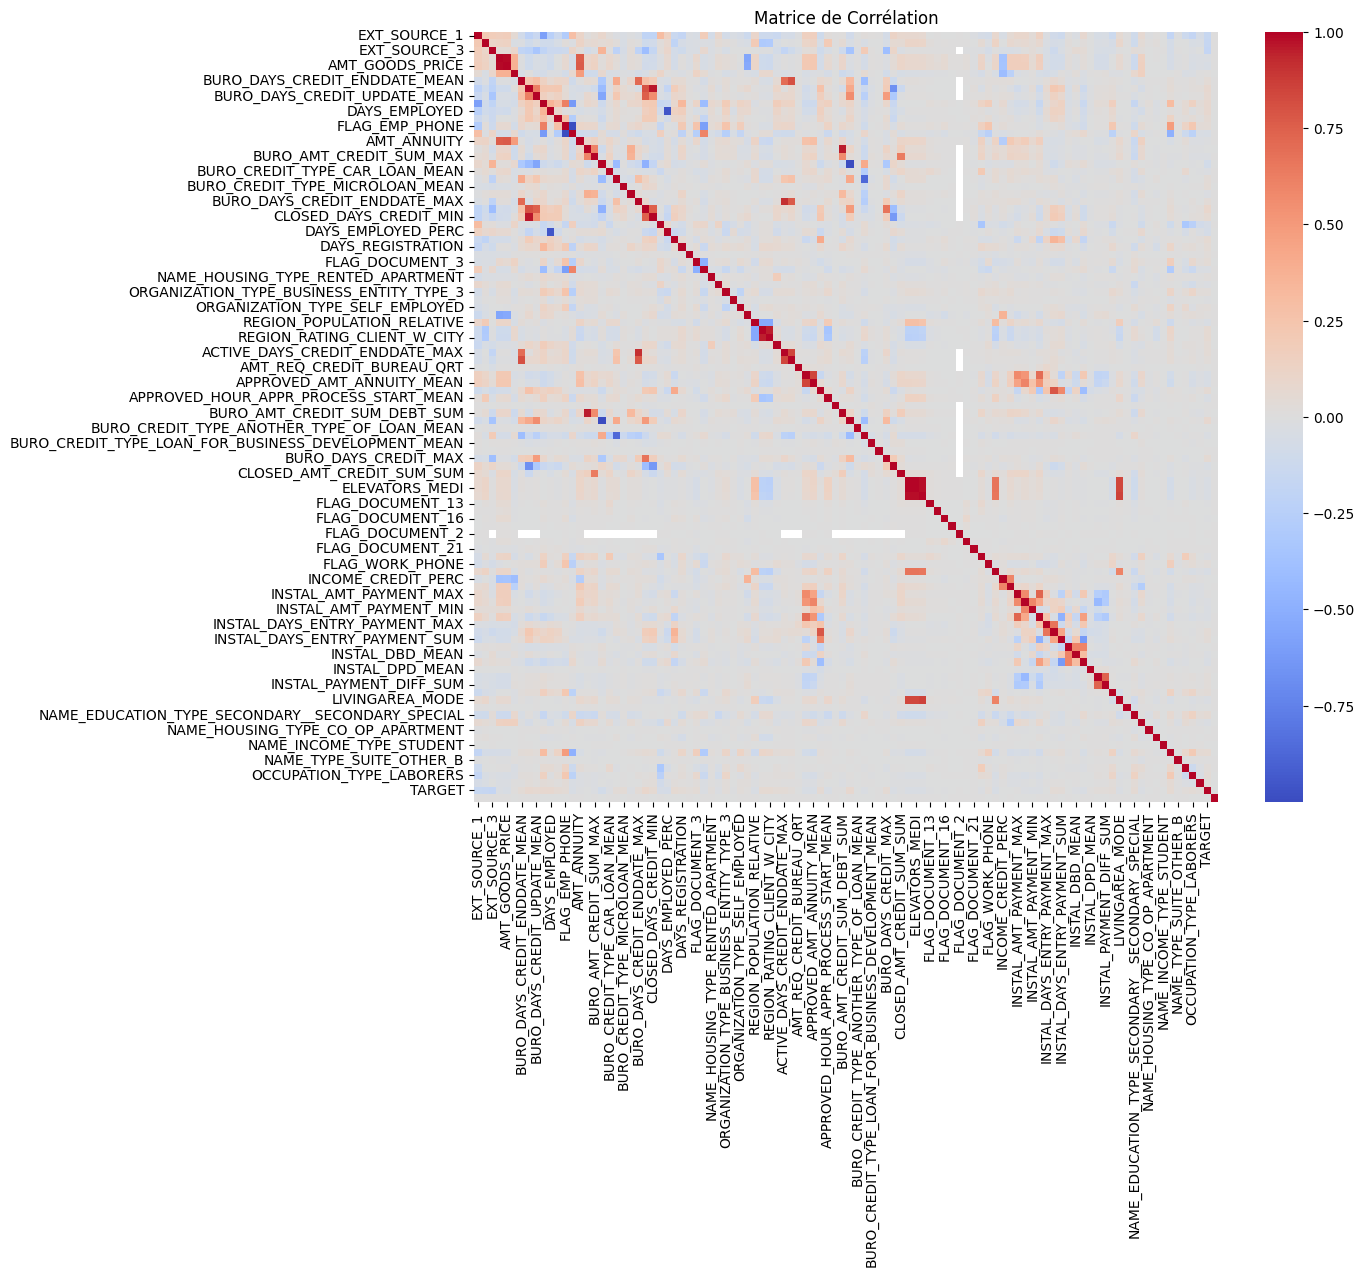

In [76]:
def calculate_correlation_matrix(df):
    """
    Calcule la matrice de corrélation et visualise les variables les plus corrélées.
    """
    corr_matrix = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Matrice de Corrélation')
    plt.show()
    return corr_matrix

# Calculer la matrice de corrélation
correlation_matrix = calculate_correlation_matrix(df_cleaned_filtered)




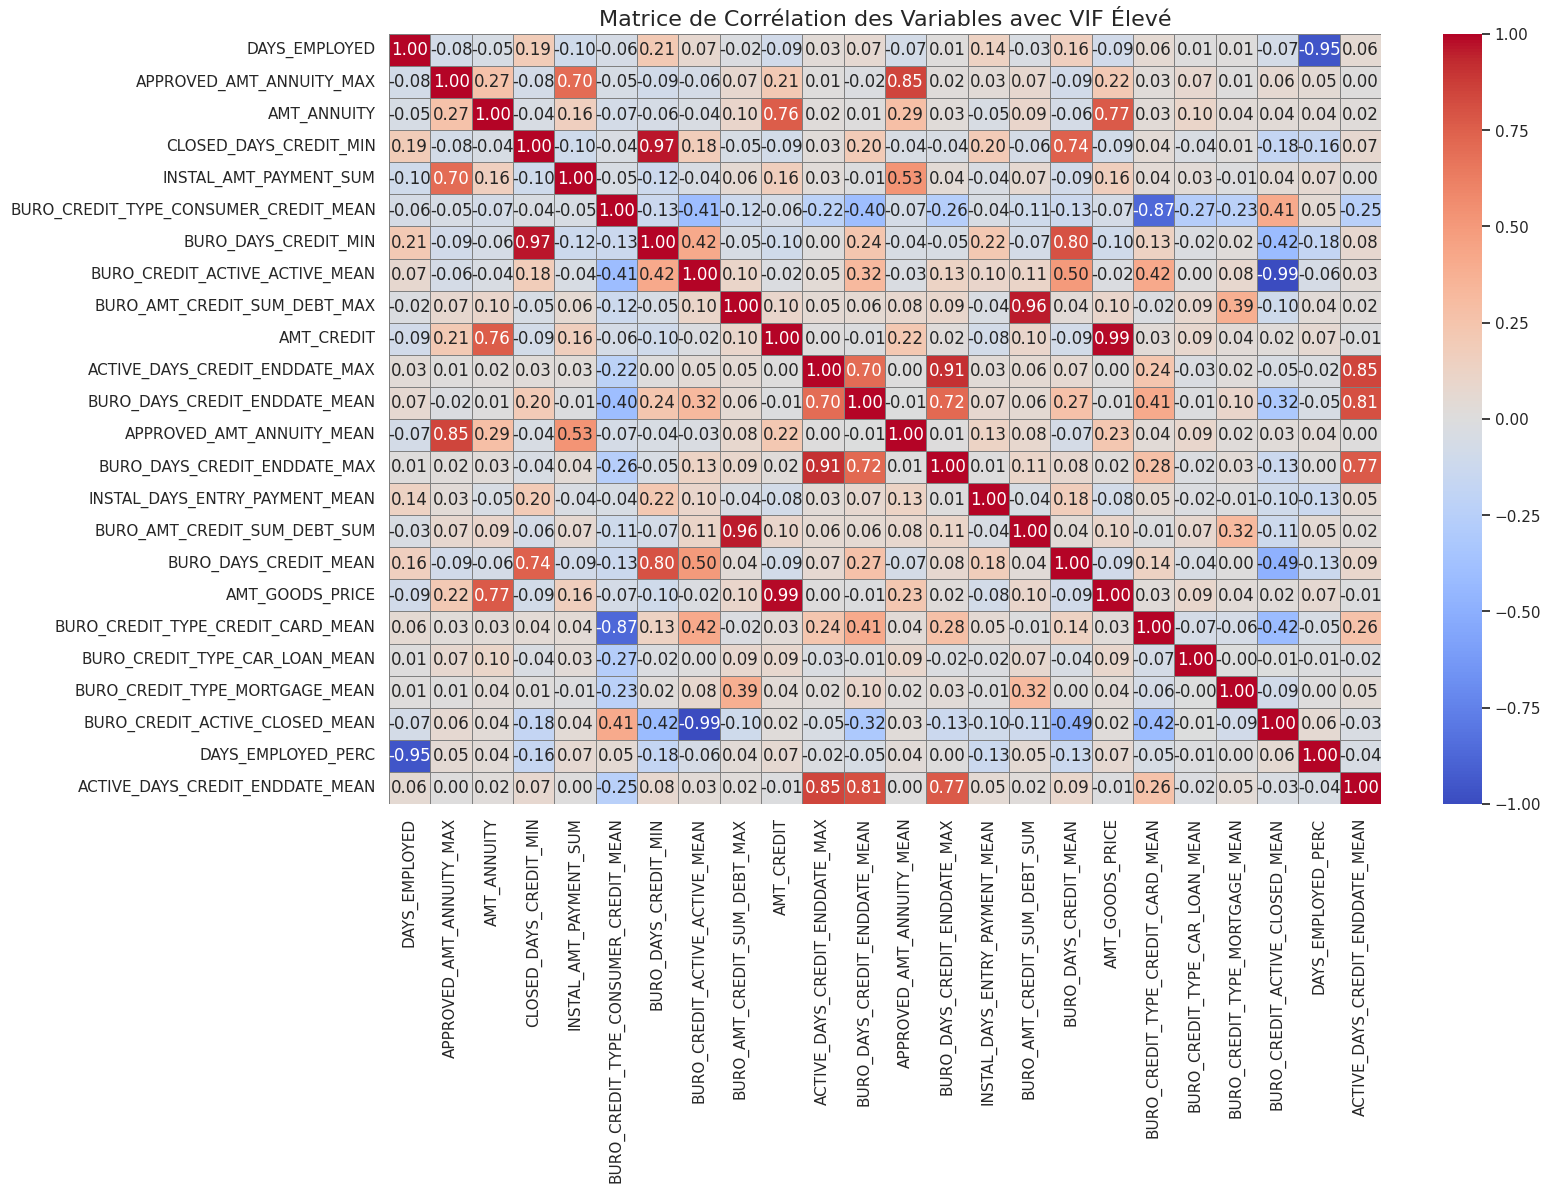

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_correlation_heatmap(df, high_vif_vars_list, title=None, cmap='coolwarm', figsize=(16, 10), mask=False):
    """
    Affiche une heatmap de la matrice de corrélation pour les variables avec un VIF élevé.

    Parameters:
        df (pd.DataFrame): Le DataFrame contenant les données.
        high_vif_vars_list (list): Liste des variables avec un VIF élevé.
        title (str, optional): Le titre de la heatmap.
        cmap (str, optional): Colormap à utiliser pour la heatmap.
        figsize (tuple, optional): Taille de la figure.
        mask (bool, optional): Masquer le triangle supérieur de la heatmap si True.
    """
    # Sélectionner les colonnes d'intérêt
    df_high_vif = df[high_vif_vars_list]

    # Calculer la matrice de corrélation
    corr_matrix = df_high_vif.corr()

    # Créer une figure avec une taille appropriée
    plt.figure(figsize=figsize)

    if not mask:
        # Générer la heatmap
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, center=0,
                    vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
    else:
        # Generate a mask for the upper triangle; True = do NOT show
        mask = np.zeros_like(corr_matrix, dtype=bool)
        mask[np.triu_indices_from(mask)] = True

        # Générer la heatmap avec le masque
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, center=0,
                    vmin=-1, vmax=1, linewidths=0.5, linecolor='white', mask=mask)

    # Ajouter un titre
    if title:
        plt.title(title, fontsize=16)

    # Afficher le plot
    plt.show()

title = "Matrice de Corrélation des Variables avec VIF Élevé"

# Utiliser la fonction pour afficher la heatmap
plot_correlation_heatmap(df_cleaned_excluded, high_vif_vars_list, title=title)


In [262]:
# Exemple d'utilisation des fonctions
with timer('high_corr_pairs'):
        # Identifier les paires de variables fortement corrélées
    high_corr_pairs = identify_high_correlation_pairs(df_cleaned_excluded[considered_features].corr(), threshold=0.9)
high_corr_pairs

high_corr_pairs - done in 11s


[('AMT_GOODS_PRICE', 'AMT_CREDIT'),
 ('NAME_INCOME_TYPE_PENSIONER', 'FLAG_EMP_PHONE'),
 ('CLOSED_DAYS_CREDIT_MIN', 'BURO_DAYS_CREDIT_MIN'),
 ('DAYS_EMPLOYED_PERC', 'DAYS_EMPLOYED'),
 ('REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT'),
 ('ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MAX'),
 ('BURO_AMT_CREDIT_SUM_DEBT_SUM', 'BURO_AMT_CREDIT_SUM_DEBT_MAX'),
 ('BURO_CREDIT_ACTIVE_ACTIVE_MEAN', 'BURO_CREDIT_ACTIVE_CLOSED_MEAN'),
 ('ELEVATORS_MEDI', 'ELEVATORS_AVG'),
 ('ELEVATORS_MODE', 'ELEVATORS_AVG'),
 ('ELEVATORS_MODE', 'ELEVATORS_MEDI')]

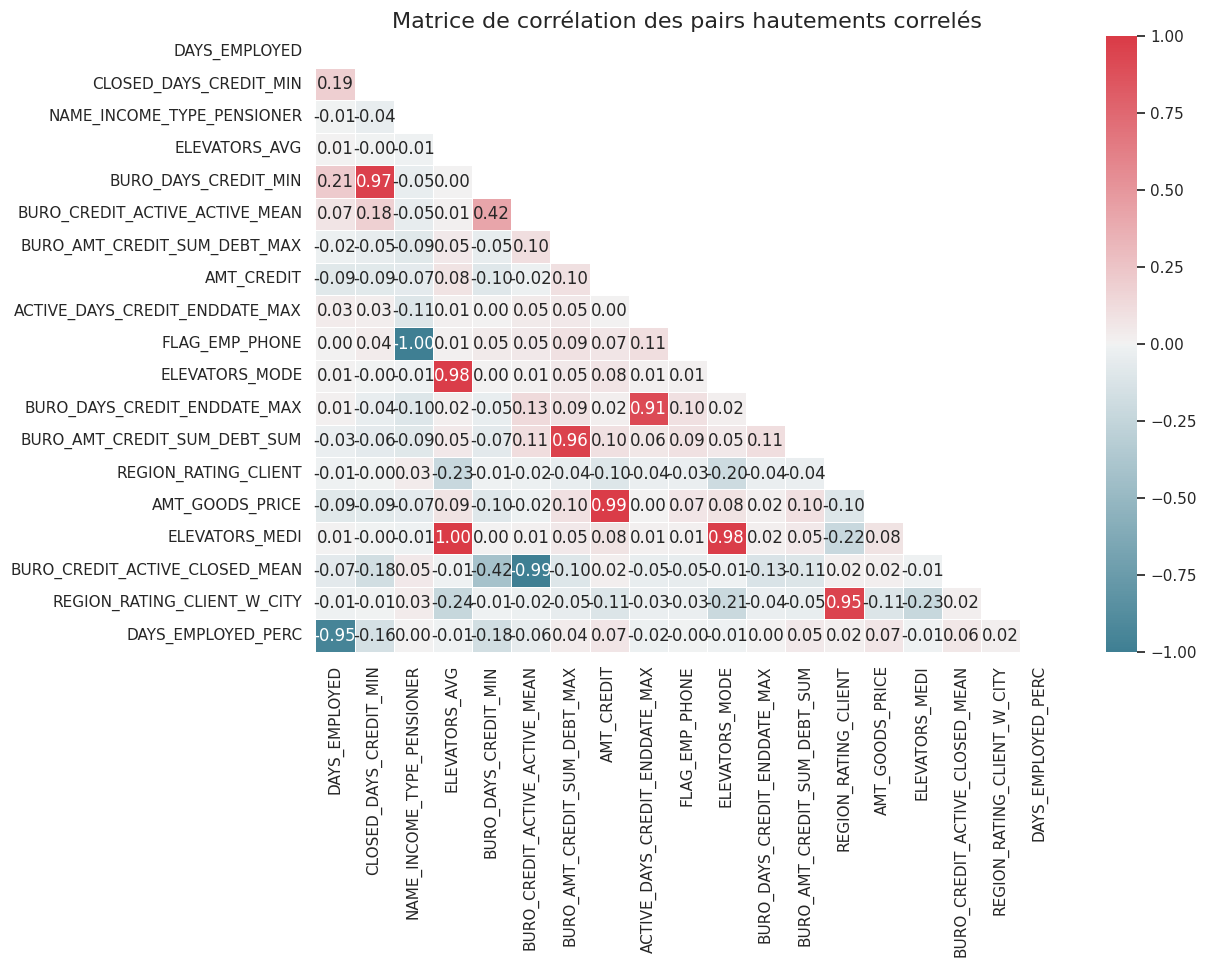

In [263]:
# Utiliser un set pour obtenir des noms uniques
unique_columns = set()

# Parcourir chaque paire et ajouter les colonnes au set
for pair in high_corr_pairs:
    unique_columns.update(pair)

# Convertir le set en une liste si nécessaire
unique_columns_list = list(unique_columns)

#print(unique_columns_list)
title = "Matrice de corrélation des pairs hautements correlés"

cmap = sns.diverging_palette(220, 10, as_cmap=True) #"PiYG"
figsize=(12, 8)
plot_correlation_heatmap(df_cleaned_excluded, unique_columns_list,title=title,cmap=cmap,figsize=figsize,mask=True)


## Multicolinéarité

In [ ]:
import pandas as pd

def compare_corr_with_target(df: pd.DataFrame, col1: str, col2: str, target: str):
    """
    Compare les corrélations de deux colonnes avec la variable cible et renvoie celle ayant la plus forte corrélation absolue.

    Paramètres :
    - df : pandas.DataFrame
        Le DataFrame contenant les données.
    - col1, col2 : str
        Les noms des deux colonnes à comparer.
    - target : str
        Le nom de la colonne cible.

    Retour :
    - dict
        Dictionnaire contenant les corrélations et la colonne recommandée pour suppression.
    """
    corr_col1 = df[col1].corr(df[target])
    corr_col2 = df[col2].corr(df[target])

    result = {
        'corr_col1': corr_col1,
        'corr_col2': corr_col2,
        'col_to_remove': col1 if abs(corr_col1) < abs(corr_col2) else col2
    }

    return result

df = df_cleaned_filtered.copy()
result = compare_corr_with_target(df, 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MAX', 'TARGET')
print(result)


import pandas as pd

def compare_feature_importance(df: pd.DataFrame, feature1: str, feature2: str):
    """
    Compare les importances des deux caractéristiques et renvoie celle ayant la plus faible importance.

    Paramètres :
    - df : pandas.DataFrame
        Le DataFrame contenant les importances des caractéristiques.
    - feature1, feature2 : str
        Les noms des deux caractéristiques à comparer.

    Retour :
    - dict
        Dictionnaire contenant les importances, la colonne recommandée pour suppression, ou des messages d'erreur pour chaque caractéristique.
    """
    # Initialiser les messages d'erreur
    errors = {}

    # Vérifier la présence de chaque caractéristique dans le DataFrame
    if feature1 not in df['feature'].values:
        errors['feature1_error'] = f"La caractéristique {feature1} n'existe pas dans le DataFrame."
    if feature2 not in df['feature'].values:
        errors['feature2_error'] = f"La caractéristique {feature2} n'existe pas dans le DataFrame."

    # Si les deux caractéristiques sont présentes, comparer leurs importances
    if feature1 in df['feature'].values and feature2 in df['feature'].values:
        importance1 = df.loc[df['feature'] == feature1, 'importance'].values[0]
        importance2 = df.loc[df['feature'] == feature2, 'importance'].values[0]

        result = {
            'importance_col1': importance1,
            'importance_col2': importance2,
            'col_to_remove': feature1 if importance1 < importance2 else feature2
        }
        return result

    # Si au moins une caractéristique est manquante, retourner les messages d'erreur
    return errors

# Exemple d'utilisation
importance_df = lgbm_labeled.copy()
result = compare_feature_importance(importance_df, 'ACTIVE_', 'AMT_CREDIT')
print(result)




{'corr_col1': 0.04441422083734675, 'corr_col2': 0.03658813758653067, 'col_to_remove': 'BURO_DAYS_CREDIT_ENDDATE_MAX'}
{'feature1_error': "La caractéristique ACTIVE_ n'existe pas dans le DataFrame."}


In [ ]:
import pandas as pd

# Exemple d'utilisation
importance_df = lgbm_labeled.copy()
result = compare_feature_importance(importance_df, 'PAYMENT_RATE', 'AMT_CREDIT')
print(result)


{'importance_col1': 1146.3, 'importance_col2': 339.5, 'col_to_remove': 'AMT_CREDIT'}


In [214]:
importance_df

,rank,feature,importance,model,feature_type
0,0,PAYMENT_RATE,1146.30,lgbm,important
1,1,EXT_SOURCE_1,1035.70,lgbm,important
2,2,EXT_SOURCE_3,987.60,lgbm,important
3,3,EXT_SOURCE_2,961.70,lgbm,important
4,4,DAYS_BIRTH,757.00,lgbm,important
...,...,...,...,...,...
790,790,CC_NAME_CONTRACT_STATUS_NAN_MEAN,0.00,lgbm,remaining
791,791,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,0.00,lgbm,remaining
792,792,CC_NAME_CONTRACT_STATUS_NAN_MIN,0.00,lgbm,remaining
793,793,PREV_NAME_CONTRACT_STATUS_NAN_MEAN,0.00,lgbm,remaining


In [48]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(dataframe, considered_features):
    df = dataframe.copy()
    X = df[considered_features].copy()

    # Convertir les colonnes booléennes en int
    bool_cols = X.select_dtypes(include=['bool']).columns
    X.loc[:, bool_cols] = X[bool_cols].astype(int)

    # Remplacer les valeurs infinies par NaN
    X = X.replace([np.inf, -np.inf], np.nan)

    # Supprimer les lignes avec des NaN
    X.dropna(inplace=True)

    # Vérifiez la variance des colonnes, retirer les colonnes avec variance nulle
    low_variance_cols = X.columns[X.var() == 0]
    if len(low_variance_cols) > 0:
        print(f"Colonnes avec variance nulle : {list(low_variance_cols)}")
        X = X.drop(columns=low_variance_cols)

    # Ajouter une constante pour le calcul du VIF
    X['intercept'] = 1

    # Créer un DataFrame pour stocker les valeurs du VIF
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Supprimer la constante de l'analyse du VIF
    vif = vif[vif['Variable'] != 'intercept']
    return vif.sort_values('VIF', ascending=False)



In [264]:
# Exemple d'utilisation des fonctions
with timer('high_corr_pairs'):
        # Identifier les paires de variables fortement corrélées
    high_corr_pairs = identify_high_correlation_pairs(df_cleaned_excluded[considered_features].corr(), threshold=0.8)
high_corr_pairs

high_corr_pairs - done in 11s


[('AMT_GOODS_PRICE', 'AMT_CREDIT'),
 ('NAME_INCOME_TYPE_PENSIONER', 'FLAG_EMP_PHONE'),
 ('CLOSED_DAYS_CREDIT_MIN', 'BURO_DAYS_CREDIT_MIN'),
 ('DAYS_EMPLOYED_PERC', 'DAYS_EMPLOYED'),
 ('REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT'),
 ('ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MAX'),
 ('ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'BURO_DAYS_CREDIT_ENDDATE_MEAN'),
 ('ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX'),
 ('APPROVED_AMT_ANNUITY_MEAN', 'APPROVED_AMT_ANNUITY_MAX'),
 ('BURO_AMT_CREDIT_SUM_DEBT_SUM', 'BURO_AMT_CREDIT_SUM_DEBT_MAX'),
 ('BURO_CREDIT_ACTIVE_ACTIVE_MEAN', 'BURO_CREDIT_ACTIVE_CLOSED_MEAN'),
 ('BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN',
  'BURO_CREDIT_TYPE_CREDIT_CARD_MEAN'),
 ('ELEVATORS_MEDI', 'ELEVATORS_AVG'),
 ('ELEVATORS_MODE', 'ELEVATORS_AVG'),
 ('ELEVATORS_MODE', 'ELEVATORS_MEDI'),
 ('LIVINGAREA_MODE', 'ELEVATORS_AVG'),
 ('LIVINGAREA_MODE', 'ELEVATORS_MEDI'),
 ('LIVINGAREA_MODE', 'ELEVATORS_MODE')]

In [119]:
df_cleaned_excluded[common_elements].shape
unique_to_list1, unique_to_list2, common_elements = extract_comparison_lists(comparison_result)
current_elements = considered_features.copy()
print(len(current_elements)
)
print(len(common_elements)
)


100
72


In [117]:
high_vif_vars_int.sort_values(by='VIF',ascending=False)

,VIF,Tolerance
FLAG_DOCUMENT_2,10000000000.00,0.00
BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN,344.42,0.00
BURO_CREDIT_TYPE_CREDIT_CARD_MEAN,295.44,0.00
ELEVATORS_MEDI,163.66,0.01
ELEVATORS_AVG,134.78,0.01
BURO_CREDIT_ACTIVE_ACTIVE_MEAN,63.63,0.02
BURO_CREDIT_ACTIVE_CLOSED_MEAN,63.60,0.02
AMT_CREDIT,48.26,0.02
AMT_GOODS_PRICE,42.73,0.02
BURO_CREDIT_TYPE_CAR_LOAN_MEAN,39.88,0.03


In [ ]:
'FLAG_DOCUMENT_2','BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN','ELEVATORS_MEDI',
'BURO_CREDIT_ACTIVE_ACTIVE_MEAN','AMT_GOODS_PRICE','ELEVATORS_MODE','DAYS_EMPLOYED',
'CLOSED_DAYS_CREDIT_MIN','BURO_AMT_CREDIT_SUM_DEBT_MAX','ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
'INSTAL_DAYS_ENTRY_PAYMENT_MEAN','REGION_RATING_CLIENT','AMT_ANNUITY','BURO_DAYS_CREDIT_MIN','APPROVED_AMT_ANNUITY_MAX'

In [121]:
#current_elements = considered_features.copy()
elements_to_remove = ['FLAG_DOCUMENT_2','BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN',
                      'ELEVATORS_MEDI','BURO_CREDIT_ACTIVE_ACTIVE_MEAN','AMT_GOODS_PRICE','ELEVATORS_MODE','DAYS_EMPLOYED',
                      'CLOSED_DAYS_CREDIT_MIN','BURO_AMT_CREDIT_SUM_DEBT_MAX','ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
                      'INSTAL_DAYS_ENTRY_PAYMENT_MEAN','REGION_RATING_CLIENT','AMT_ANNUITY','BURO_DAYS_CREDIT_MIN','APPROVED_AMT_ANNUITY_MAX']

#current_elements.remove('FLAG_DOCUMENT_2')
# Filtrer la liste pour exclure les éléments à supprimer
current_elements = [elem for elem in current_elements if elem not in elements_to_remove]

#considered_features = high_vif_vars_list
# columns_to_del = ['' ]
with timer('Calculate VIF'):
    df_cleaned_excluded = df_cleaned_filtered.copy()
    columns_to_exclude = ['TARGET', 'SK_ID_CURR']
    considered_features = [col for col in df_cleaned_excluded.columns if col not in columns_to_exclude]

    # Calculer le VIF
    vif_result, high_vif_vars, vif_result_styled = calculate_vif(df_cleaned_excluded[current_elements], threshold=5, color='#1ba6ab')
    print("Taille du dataframe de travaille",df_cleaned_excluded[current_elements].shape)
    print(f"VIF des {len(current_elements)} colonnes en commun :")

vif_result_styled


VIF des colonnes :
Taille du dataframe de travaille (356251, 85)
VIF des 85 colonnes en commun :
Calculate VIF - done in 13s


,VIF,Tolerance
EXT_SOURCE_1,1.644209,0.608195
EXT_SOURCE_2,1.211056,0.825726
EXT_SOURCE_3,1.308615,0.764167
AMT_CREDIT,2.878142,0.347446
ANNUITY_INCOME_PERC,2.405113,0.415781
BURO_DAYS_CREDIT_ENDDATE_MEAN,4.699187,0.212803
BURO_DAYS_CREDIT_UPDATE_MEAN,2.357433,0.424190
DAYS_BIRTH,1.679374,0.595460
DAYS_ID_PUBLISH,1.072156,0.932700
FLAG_EMP_PHONE,1.001326,0.998675


1. Compare Corrélation avec la Cible (compare_corr_with_target)

    Objectif : Comparer les corrélations de deux caractéristiques avec la variable cible (TARGET) et déterminer laquelle a la plus faible corrélation absolue. Je souhaite conserver celle qui a la plus forte corrélation absolue (car elle est probablement plus informative).
    Fonctionnement :
        La fonction calcule les corrélations de col1 et col2 avec TARGET.
        Elle retourne la colonne à supprimer, c'est-à-dire celle ayant la plus faible corrélation absolue avec TARGET.

2. Comparer l'Importance des Caractéristiques (compare_feature_importance)

    Objectif : Comparer l'importance de deux caractéristiques dans un modèle (par exemple, un modèle d'arbre) et déterminer laquelle a la plus faible importance pour la suppression.
    Fonctionnement :
        La fonction prend un DataFrame importance_df contenant des colonnes feature et importance.
        Elle compare les importances de feature1 et feature2.
        Elle retourne la colonne à supprimer, c'est-à-dire celle ayant la plus faible importance.


In [217]:
result = compare_corr_with_target(df_cleaned_filtered, 'BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN', 'BURO_CREDIT_TYPE_CREDIT_CARD_MEAN', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN', 'BURO_CREDIT_TYPE_CREDIT_CARD_MEAN')
print(result)


{'corr_col1': -0.026259283917954578, 'corr_col2': 0.0346856445262761, 'col_to_remove': 'BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN'}
{'importance_col1': 104.6, 'importance_col2': 119.3, 'col_to_remove': 'BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN'}


In [219]:
result = compare_corr_with_target(df_cleaned_filtered, 'ELEVATORS_MEDI', 'ELEVATORS_AVG', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'ELEVATORS_MEDI', 'ELEVATORS_AVG')
print(result)


{'corr_col1': -0.03386632428853536, 'corr_col2': -0.03420227894417563, 'col_to_remove': 'ELEVATORS_MEDI'}
{'importance_col1': 7.6, 'importance_col2': 20.9, 'col_to_remove': 'ELEVATORS_MEDI'}


In [233]:
result = compare_corr_with_target(df_cleaned_filtered, 'ELEVATORS_MODE', 'ELEVATORS_AVG', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'ELEVATORS_MODE', 'ELEVATORS_AVG')
print(result)


{'corr_col1': -0.032134505315191096, 'corr_col2': -0.03420227894417563, 'col_to_remove': 'ELEVATORS_MODE'}
{'importance_col1': 11.4, 'importance_col2': 20.9, 'col_to_remove': 'ELEVATORS_MODE'}


In [221]:
result = compare_corr_with_target(df_cleaned_filtered, 'BURO_CREDIT_ACTIVE_ACTIVE_MEAN', 'BURO_CREDIT_ACTIVE_CLOSED_MEAN', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'BURO_CREDIT_ACTIVE_ACTIVE_MEAN', 'BURO_CREDIT_ACTIVE_CLOSED_MEAN')
print(result)

{'corr_col1': 0.07735592009729873, 'corr_col2': -0.0793694441102374, 'col_to_remove': 'BURO_CREDIT_ACTIVE_ACTIVE_MEAN'}
{'importance_col1': 73.5, 'importance_col2': 97.1, 'col_to_remove': 'BURO_CREDIT_ACTIVE_ACTIVE_MEAN'}


In [239]:
result = compare_corr_with_target(df_cleaned_filtered, 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC')
print(result)


{'corr_col1': 0.07495658541677348, 'corr_col2': -0.06795164769745918, 'col_to_remove': 'DAYS_EMPLOYED_PERC'}
{'importance_col1': 541.2, 'importance_col2': 398.5, 'col_to_remove': 'DAYS_EMPLOYED_PERC'}


In [242]:
result = compare_corr_with_target(df_cleaned_filtered, 'BURO_DAYS_CREDIT_MIN', 'CLOSED_DAYS_CREDIT_MIN', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'BURO_DAYS_CREDIT_MIN', 'CLOSED_DAYS_CREDIT_MIN')
print(result)


{'corr_col1': 0.07524766201022295, 'corr_col2': 0.06119369830609864, 'col_to_remove': 'CLOSED_DAYS_CREDIT_MIN'}
{'importance_col1': 146.2, 'importance_col2': 108.3, 'col_to_remove': 'CLOSED_DAYS_CREDIT_MIN'}


In [243]:
result = compare_corr_with_target(df_cleaned_filtered, 'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'BURO_AMT_CREDIT_SUM_DEBT_SUM')
print(result)


{'corr_col1': -0.0021730848753387694, 'corr_col2': 0.007145325041830084, 'col_to_remove': 'BURO_AMT_CREDIT_SUM_DEBT_MAX'}
{'importance_col1': 98.9, 'importance_col2': 127.7, 'col_to_remove': 'BURO_AMT_CREDIT_SUM_DEBT_MAX'}


In [245]:
result = compare_corr_with_target(df_cleaned_filtered, 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MAX', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MAX')
print(result)



{'corr_col1': 0.04441422083734675, 'corr_col2': 0.03658813758653067, 'col_to_remove': 'BURO_DAYS_CREDIT_ENDDATE_MAX'}
{'importance_col1': 250.6, 'importance_col2': 263.4, 'col_to_remove': 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX'}


In [248]:
result = compare_corr_with_target(df_cleaned_filtered, 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT')
print(result)



{'corr_col1': 0.06089474616033852, 'corr_col2': 0.0589008793727423, 'col_to_remove': 'REGION_RATING_CLIENT'}
{'importance_col1': 109.6, 'importance_col2': 19.4, 'col_to_remove': 'REGION_RATING_CLIENT'}


In [122]:
lgbm_labeled[lgbm_labeled['feature']=='PAYMENT_RATE']

,rank,feature,importance,model,feature_type
0,0,PAYMENT_RATE,1146.30,lgbm,important


In [265]:
#PAYMENT_RATE, est une combinaison des deux. Cette variable peut capturer l'essence des deux informations en une seule,
#indiquant combien de crédit est remboursé à chaque période.
result = compare_corr_with_target(df_cleaned_filtered, 'AMT_ANNUITY', 'AMT_CREDIT', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'AMT_ANNUITY', 'AMT_CREDIT')
print(result)


{'corr_col1': -0.012818497233817389, 'corr_col2': -0.0303712757528969, 'col_to_remove': 'AMT_ANNUITY'}
{'importance_col1': 553.6, 'importance_col2': 339.5, 'col_to_remove': 'AMT_CREDIT'}


In [250]:
result = compare_corr_with_target(df_cleaned_filtered, 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'AMT_CREDIT', 'AMT_GOODS_PRICE')
print(result)



{'corr_col1': -0.0303712757528969, 'corr_col2': -0.03964669449611322, 'col_to_remove': 'AMT_CREDIT'}
{'importance_col1': 339.5, 'importance_col2': 335.2, 'col_to_remove': 'AMT_GOODS_PRICE'}


In [266]:
result = compare_corr_with_target(df_cleaned_filtered, 'BURO_DAYS_CREDIT_MEAN', 'BURO_DAYS_CREDIT_MIN', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'BURO_DAYS_CREDIT_MEAN', 'BURO_DAYS_CREDIT_MIN')
print(result)


{'corr_col1': 0.08973059094742099, 'corr_col2': 0.07524766201022295, 'col_to_remove': 'BURO_DAYS_CREDIT_MIN'}
{'importance_col1': 207.2, 'importance_col2': 146.2, 'col_to_remove': 'BURO_DAYS_CREDIT_MIN'}


In [268]:
result = compare_corr_with_target(df_cleaned_filtered, 'APPROVED_AMT_ANNUITY_MAX', 'APPROVED_AMT_ANNUITY_MEAN', 'TARGET')
print(result)

result = compare_feature_importance(importance_df, 'APPROVED_AMT_ANNUITY_MAX', 'APPROVED_AMT_ANNUITY_MEAN')
print(result)


{'corr_col1': -0.04391553016439395, 'corr_col2': -0.04449921265573097, 'col_to_remove': 'APPROVED_AMT_ANNUITY_MAX'}
{'importance_col1': 123.2, 'importance_col2': 194.2, 'col_to_remove': 'APPROVED_AMT_ANNUITY_MAX'}


In [131]:
df_red = df_cleaned_filtered.copy()
df_red = df_red.drop(columns=elements_to_remove)
# Vérifier les dimensions du DataFrame filtré
print(f"Dimensions du DataFrame filtré : {df_red.shape}")

# Sauvegarder le DataFrame filtré dans un fichier CSV
df_red.to_csv('/content/drive/MyDrive/Python/OCRP/Projet07/working/data/data_df_85_features.csv', index=False)

print("DataFrame avec les meilleures caractéristiques sauvegardé avec succès.")

Dimensions du DataFrame filtré : (356251, 87)
DataFrame avec les meilleures caractéristiques sauvegardé avec succès.


In [ ]:
df_cleaned_filtered = pd.read_csv('/content/drive/MyDrive/Python/OCRP/Projet07/working/data/data_df_85_features.csv')
print(f"Taille du DataFrame des features est : {df_cleaned_filtered.shape}")

In [273]:
import pandas as pd

def find_columns_with_prefix(df, prefix):
    """
    Affiche toutes les colonnes dans le DataFrame qui commencent par le préfixe spécifié.

    Parameters:
        df (pd.DataFrame): Le DataFrame contenant les données.
        prefix (str): Le préfixe à rechercher dans les noms des colonnes.

    Returns:
        list: Une liste des noms de colonnes qui commencent par le préfixe spécifié.
    """
    # Trouver les colonnes qui commencent par le préfixe donné
    matching_columns = [col for col in df.columns if col.startswith(prefix)]

    # Afficher les colonnes trouvées
    if matching_columns:
        print(f"Colonnes commençant par '{prefix}':")
        for col in matching_columns:
            print(col)
    else:
        print(f"Aucune colonne ne commence par '{prefix}'.")

    return matching_columns
columns_with_prefix = find_columns_with_prefix(df_cleaned_excluded[current_elements], 'INCOME')

Colonnes commençant par 'INCOME':
INCOME_CREDIT_PERC
INCOME_PER_PERSON


In [11]:
list_endofcorr = common_elements.copy()

- Je vais examiner, par paires, les corrélations avec la variable cible et le rang d'importance des caractéristiques ayant un VIF élevé, afin de décider lesquelles supprimer.

In [13]:
print(list_endofcorr)

['INCOME_PER_PERSON', 'CLOSED_AMT_CREDIT_SUM_SUM', 'INSTAL_DPD_MEAN', 'DAYS_REGISTRATION', 'FLAG_DOCUMENT_3', 'BURO_DAYS_CREDIT_MEAN', 'REG_CITY_NOT_LIVE_CITY', 'INSTAL_AMT_PAYMENT_MIN', 'LIVINGAREA_MODE', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'BURO_CREDIT_TYPE_MORTGAGE_MEAN', 'PAYMENT_RATE', 'APPROVED_HOUR_APPR_PROCESS_START_MEAN', 'DAYS_EMPLOYED_PERC', 'EXT_SOURCE_3', 'BURO_DAYS_CREDIT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'BURO_DAYS_CREDIT_VAR', 'DAYS_EMPLOYED', 'BURO_DAYS_CREDIT_MIN', 'ANNUITY_INCOME_PERC', 'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'REGION_POPULATION_RELATIVE', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'BURO_CREDIT_ACTIVE_ACTIVE_MEAN', 'AMT_REQ_CREDIT_BUREAU_QRT', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN', 'ORGANIZATION_TYPE_SELF_EMPLOYED', 'INSTAL_PAYMENT_DIFF_SUM', 'DEF_60_CNT_SOCIAL_CIRCLE', 'INCOME_CREDIT_PERC', 'EXT_SOURCE_2', 'AMT_CREDIT', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'DAYS_LAST_PHONE_CHANGE', 'APPROVED_AMT_ANNUITY_MAX', 'FLAG_WORK_PHONE', 'A

In [129]:
# recalculate correlations
correlations_subset = calc_target_correlations(df_red, 'TARGET').sort_values(by='abs_corr', ascending=False)
# verifié que les bas correlationsont été supprimés
correlations_subset.sort_values(by='abs_corr', ascending=False).head()

,col,correlation,abs_corr
2,EXT_SOURCE_3,-0.18,0.18
1,EXT_SOURCE_2,-0.16,0.16
0,EXT_SOURCE_1,-0.16,0.16
18,BURO_DAYS_CREDIT_MEAN,0.09,0.09
12,BURO_CREDIT_ACTIVE_CLOSED_MEAN,-0.08,0.08


In [132]:
suite = ['BURO_DAYS_CREDIT_ENDDATE_MEAN','INSTAL_AMT_PAYMENT_SUM','INSTAL_AMT_PAYMENT_MEAN','ELEVATORS_AVG',
'BURO_DAYS_CREDIT_MEAN','BURO_DAYS_CREDIT_ENDDATE_MEAN']

In [102]:
# compute vif values after removing a feature

columns_to_remove = ['FLAG_DOCUMENT_2','BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN',
                      'ELEVATORS_MEDI','BURO_CREDIT_ACTIVE_ACTIVE_MEAN','AMT_GOODS_PRICE','ELEVATORS_MODE','DAYS_EMPLOYED',
                      'CLOSED_DAYS_CREDIT_MIN','BURO_AMT_CREDIT_SUM_DEBT_MAX','ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
                      'INSTAL_DAYS_ENTRY_PAYMENT_MEAN','REGION_RATING_CLIENT','AMT_CREDIT','BURO_DAYS_CREDIT_MIN','APPROVED_AMT_ANNUITY_MAX']

#considered_features = high_vif_vars_list
compute_vif(df_cleaned_excluded,columns_to_remove)


Colonnes avec variance nulle : ['FLAG_DOCUMENT_2']


,Variable,VIF
3,AMT_GOODS_PRICE,37.48
11,AMT_CREDIT,37.41
1,ELEVATORS_MEDI,30.43
4,ELEVATORS_MODE,30.17
6,CLOSED_DAYS_CREDIT_MIN,12.35
12,BURO_DAYS_CREDIT_MIN,11.93
2,BURO_CREDIT_ACTIVE_ACTIVE_MEAN,1.37
0,BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN,1.22
10,REGION_RATING_CLIENT,1.08
13,APPROVED_AMT_ANNUITY_MAX,1.07


In [112]:
from sklearn.base import BaseEstimator, TransformerMixin
# from statsmodels.stats.outliers_influence import variance_inflation_factor



def calculate_vif(df, feature_subset=None, target_cols=None):
    """
    Calculate Variance Inflation Factor (VIF) for each feature
    modified version from original at
    https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f
     """
    if feature_subset is None:
        feature_subset = df.select_dtypes(include='number').columns
    features = sorted(list(set(feature_subset) - set(target_cols)))
    vif, tolerance = {}, {}
    df = df[features].dropna()
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        x = [f for f in features if f != feature]
        x, y = df[x], df[feature]
        # extract r-squared from the fit
        model = LinearRegression().fit(x, y)
        r2 = model.score(x, y)
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF (add 0.001 to avoid warnings 'division by zero')
        vif[feature] = 1 / (tolerance[feature]+0.0001)
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

def find_high_vif_features_to_drop(X, y=None, thresh=5, cols_to_keep=None,
                                   feature_subset=None, target_cols=None,
                                   debug=False):
    """
    Choisir les variables avec un fort VIF (Variance Inflation Factor) pour les supprimer.
    Comment supprimer systématiquement les variables collinéaires.
    """
    if feature_subset is None:
        feature_subset = X.select_dtypes(include='number').columns
        print(f'{len(feature_subset)} features from {len(X.columns)}')

    if target_cols is None:
        target_cols = ['TARGET']

    if y is None:
        cible = target_cols[0]
        if cible in X.columns:
            y = X[cible]
    else:
        cible = getattr(y, 'name', target_cols[0])

    # Initialisation des colonnes restantes et des colonnes à supprimer
    remaining_cols = list(X.columns)
    high_vif_features_to_drop = []

    # Columns to take into account in vif calculation
    feature_subset = set(feature_subset) - set(target_cols)

    # Si `cols_to_keep` n'est pas None, enlever ces colonnes du `feature_subset`
    if cols_to_keep is not None:
        feature_subset = list(feature_subset - set(cols_to_keep))
    else:
        feature_subset = list(feature_subset)

    # Cache pour les corrélations déjà calculées
    corr_cache = {}

    dropped = True
    while dropped:
        dropped = False
        df_new = X[remaining_cols].copy()
        vif_df = calculate_vif(df_new, feature_subset=feature_subset, target_cols=target_cols)
        max_vif = vif_df['VIF'].max()
        col_name = vif_df['VIF'].idxmax()

        min_tolerance = vif_df['Tolerance'].min()
        if min_tolerance == 0 and y is not None:
            if debug:
                print('Colonnes collinéaires (r2_score=1, tolérance=0, VIF=inf):')
            # Choisir la colonne avec la plus faible corrélation avec la cible y
            infinite_vif_cols = vif_df[vif_df['Tolerance'] == 0].index.values
            min_corr = 10
            for col in infinite_vif_cols:
                col_corr = corr_cache.get(col, -99)
                if col_corr > -1:
                    correln = col_corr
                else:
                    correln = np.abs(X[col].corr(y))
                    corr_cache[col] = correln
                if debug:
                    print(f'   corr({col}, {cible})={correln:.3}')
                if correln < min_corr:
                    col_name = col
                    min_corr = correln

        if max_vif > thresh:
            print(f'Suppression de {col_name} avec VIF = {max_vif:.3f}')
            high_vif_features_to_drop.append(col_name)
            df_new = df_new.drop(col_name, axis=1)
            remaining_cols = list(df_new.columns)
            feature_subset = list(set(feature_subset).intersection(set(remaining_cols)))
            dropped = True

    print(f'high_vif_features_to_drop = {high_vif_features_to_drop}')
    return high_vif_features_to_drop


df_test = df_cleaned_filtered.copy()
find_high_vif_features_to_drop(df_test, thresh=5)

85 features from 102
Suppression de FLAG_DOCUMENT_2 avec VIF = 10000.000
Suppression de BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN avec VIF = 332.952
Suppression de ELEVATORS_MEDI avec VIF = 161.034
Suppression de BURO_CREDIT_ACTIVE_ACTIVE_MEAN avec VIF = 62.921
Suppression de AMT_CREDIT avec VIF = 48.032
Suppression de DAYS_EMPLOYED avec VIF = 27.570
Suppression de ELEVATORS_MODE avec VIF = 27.293
Suppression de BURO_DAYS_CREDIT_MIN avec VIF = 15.617
Suppression de BURO_AMT_CREDIT_SUM_DEBT_MAX avec VIF = 15.173
Suppression de ACTIVE_DAYS_CREDIT_ENDDATE_MAX avec VIF = 8.336
Suppression de INSTAL_DAYS_ENTRY_PAYMENT_MEAN avec VIF = 7.549
Suppression de REGION_RATING_CLIENT avec VIF = 7.329
Suppression de AMT_GOODS_PRICE avec VIF = 6.509
Suppression de APPROVED_AMT_ANNUITY_MAX avec VIF = 5.858
Suppression de BURO_DAYS_CREDIT_MEAN avec VIF = 5.854
high_vif_features_to_drop = ['FLAG_DOCUMENT_2', 'BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN', 'ELEVATORS_MEDI', 'BURO_CREDIT_ACTIVE_ACTIVE_MEAN', 'AMT_CRE

['FLAG_DOCUMENT_2',
 'BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN',
 'ELEVATORS_MEDI',
 'BURO_CREDIT_ACTIVE_ACTIVE_MEAN',
 'AMT_CREDIT',
 'DAYS_EMPLOYED',
 'ELEVATORS_MODE',
 'BURO_DAYS_CREDIT_MIN',
 'BURO_AMT_CREDIT_SUM_DEBT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'REGION_RATING_CLIENT',
 'AMT_GOODS_PRICE',
 'APPROVED_AMT_ANNUITY_MAX',
 'BURO_DAYS_CREDIT_MEAN']

In [126]:
top_feat_corr = calc_target_correlations(df_cleaned_filtered, 'TARGET')


In [57]:
elements_to_remove

['FLAG_DOCUMENT_2',
 'BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN',
 'ELEVATORS_MEDI',
 'BURO_CREDIT_ACTIVE_ACTIVE_MEAN',
 'AMT_GOODS_PRICE',
 'ELEVATORS_MODE',
 'DAYS_EMPLOYED',
 'CLOSED_DAYS_CREDIT_MIN',
 'BURO_AMT_CREDIT_SUM_DEBT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'REGION_RATING_CLIENT',
 'AMT_CREDIT',
 'BURO_DAYS_CREDIT_MIN',
 'APPROVED_AMT_ANNUITY_MAX']

In [59]:
print(df_cleaned_filtered.var())  # Vérifiez la variance des colonnes

EXT_SOURCE_1                          4.411931e-02
EXT_SOURCE_2                          3.600630e-02
EXT_SOURCE_3                          3.769043e-02
AMT_CREDIT                            1.589021e+11
AMT_GOODS_PRICE                       1.340041e+11
                                          ...     
OCCUPATION_TYPE_DRIVERS               5.640248e-02
OCCUPATION_TYPE_LABORERS              1.470893e-01
OCCUPATION_TYPE_LOW_SKILL_LABORERS    6.591756e-03
TARGET                                7.421280e-02
SK_ID_CURR                            1.057649e+10
Length: 102, dtype: float64


In [53]:
non_numeric_cols = df_cleaned_filtered[list_endofcorr].select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['ORGANIZATION_TYPE_SELF_EMPLOYED', 'NAME_FAMILY_STATUS_MARRIED',
       'NAME_INCOME_TYPE_WORKING', 'OCCUPATION_TYPE_DRIVERS',
       'ORGANIZATION_TYPE_MILITARY',
       'NAME_EDUCATION_TYPE_SECONDARY__SECONDARY_SPECIAL',
       'ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_3'],
      dtype='object')


In [ ]:
elements_to_remove = ['FLAG_DOCUMENT_2','BURO_CREDIT_TYPE_CONSUMER_CREDIT_MEAN',
                      'ELEVATORS_MEDI','BURO_CREDIT_ACTIVE_ACTIVE_MEAN','AMT_GOODS_PRICE','ELEVATORS_MODE','DAYS_EMPLOYED',
                      'CLOSED_DAYS_CREDIT_MIN','BURO_AMT_CREDIT_SUM_DEBT_MAX','ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
                      'INSTAL_DAYS_ENTRY_PAYMENT_MEAN','REGION_RATING_CLIENT','AMT_CREDIT','BURO_DAYS_CREDIT_MIN','APPROVED_AMT_ANNUITY_MAX']

In [278]:
import pandas as pd


# Ajouter 'TARGET' et 'SK_ID_CURR' à la liste des colonnes à conserver
list_endofcorr.extend(['TARGET', 'SK_ID_CURR'])

# Vérifier que toutes les colonnes dans list_endofcorr existent dans df_cleaned_filtered
missing_cols = [col for col in list_endofcorr if col not in df_cleaned_filtered.columns]
if missing_cols:
    raise ValueError(f"Les colonnes suivantes sont manquantes dans le DataFrame : {', '.join(missing_cols)}")

# Filtrer df_cleaned_filtered pour ne conserver que les colonnes spécifiées
df_cleaned_filtered = df_cleaned_filtered[list_endofcorr]

# Vérifier les dimensions du DataFrame filtré
print(f"Dimensions du DataFrame filtré : {df_cleaned_filtered.shape}")

# Sauvegarder le DataFrame filtré dans un fichier CSV
#df_cleaned_filtered.to_csv('/kaggle/working/df_66_features.csv', index=False)

print("DataFrame avec les meilleures caractéristiques sauvegardé avec succès.")


Dimensions du DataFrame filtré : (356251, 74)
DataFrame avec les meilleures caractéristiques sauvegardé avec succès.


In [ ]:
import pandas as pd
import re
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from contextlib import contextmanager
import time

@contextmanager
def timed_block(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# Fonction pour effectuer l'encodage one-hot
def one_hot_encoder(df, nan_as_category=True):
    """
    Encodage one-hot pour les colonnes catégorielles et booléennes avec get_dummies.

    Paramètres :
    - df : pandas.DataFrame
        Le DataFrame contenant les données.
    - nan_as_category : bool, facultatif, default=True
        Indique si les NaN doivent être traités comme une catégorie à part.

    Retour :
    - df : pandas.DataFrame
        Le DataFrame avec les colonnes encodées en one-hot.
    - new_columns : list
        Liste des nouveaux noms de colonnes ajoutées lors de l'encodage.
    """

    original_columns = list(df.columns)

    # Identifier les colonnes catégorielles (type object) et booléennes
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    bool_columns = [col for col in df.columns if df[col].dtype == 'bool']

    # Combiner les colonnes catégorielles et booléennes pour l'encodage one-hot
    columns_to_encode = categorical_columns + bool_columns

    # Appliquer l'encodage one-hot
    df = pd.get_dummies(df, columns=columns_to_encode, dummy_na=nan_as_category)

    # Identifier les nouvelles colonnes créées par l'encodage one-hot
    new_columns = [c for c in df.columns if c not in original_columns]

    return df, new_columns

def clean_column_names(df):
    # Remplacer les espaces par des underscores
    df.columns = [col.replace(' ', '_') for col in df.columns]

    # Remplacer les caractères non alphanumériques par des underscores et convertir en majuscules
    df.columns = [re.sub('[^A-Za-z0-9_]+', '_', col.upper()) for col in df.columns]

    # Remplacer les doubles underscores par un seul underscore
    df.columns = [col.replace('__', '_') for col in df.columns]

    return df

# Fonction pour initialiser les données
# Fonction pour initialiser les données
def initialize_data(df, sample_fraction=0.5):
    with timer("Conversion des colonnes entières en float64"):
        int_columns = df.select_dtypes(include=['int64']).columns
        df[int_columns] = df[int_columns].astype('float64')

    with timer("Prendre un échantillon aléatoire"):
        sample_size = int(len(df) * sample_fraction)
        df_sample = df.sample(n=sample_size, random_state=42).copy()

    with timer("One-hot encoding"):
        df_encoded, new_cols = one_hot_encoder(df_sample)

    with timer("Nettoyage des noms de colonnes"):
        df_encoded = clean_column_names(df_encoded)

    with timer("Séparation des colonnes cibles et d'identification"):
        features = df_encoded.drop(['TARGET', 'SK_ID_CURR', 'INDEX'], axis=1)  # Exclure 'TARGET', 'SK_ID_CURR' et 'INDEX'
        target = df_encoded['TARGET']  # Colonne cible
        ids = df_encoded['SK_ID_CURR']  # Colonne d'identification

    with timer("Traitement des valeurs manquantes dans la colonne cible"):
        target = target.dropna()
        features = features.loc[target.index]
        ids = ids.loc[target.index]

    with timer("Imputation des valeurs manquantes avec la médiane"):
        imputer = SimpleImputer(strategy='median')
        features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns, index=features.index)

    with timer("Réintégration des colonnes cibles et d'identification"):
        df_imputed = pd.concat([features_imputed, target, ids], axis=1)

    with timer("Split stratifié des données avec set de validation"):
        X = df_imputed.drop(['TARGET'], axis=1)  # Features sans la colonne cible
        y = df_imputed['TARGET']  # Colonne cible

        # Split initial en train + validation et test
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        # Split du train_val en train et validation
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

    return X, y, X_train, X_val, X_test, y_train, y_val, y_test

X, y, X_train, X_val, X_test, y_train, y_val, y_test = initialize_data(df, sample_fraction=1.0)


Conversion des colonnes entières en float64 - done in 0s
Prendre un échantillon aléatoire - done in 6s
One-hot encoding - done in 3s
Nettoyage des noms de colonnes - done in 0s
Séparation des colonnes cibles et d'identification - done in 1s
Remplacement des valeurs infinies par NaN - done in 1s
Traitement des valeurs manquantes dans la colonne cible - done in 1s
Imputation des valeurs manquantes avec la médiane - done in 111s
Réintégration des colonnes cibles et d'identification - done in 1s
Split stratifié des données avec set de validation - done in 6s


In [ ]:
df.dtypes.value_counts()

,count
float64,649
bool,133
object,16


In [ ]:
X.shape

(307507, 1089)

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer la PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculer la variance expliquée cumulée
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Déterminer le nombre de composantes pour 95% et 99% de variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

print(f"Nombre de composantes pour 95% de variance : {n_components_95}")
print(f"Nombre de composantes pour 99% de variance : {n_components_99}")


Nombre de composantes pour 95% de variance : 393
Nombre de composantes pour 99% de variance : 487


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer la PCA
pca = PCA(n_components=n_components_99)  # Supposons que nous voulons n_components_99 composantes pour cet exemple
X_pca = pca.fit_transform(X_scaled)

# Poids des variables pour chaque composante
components = pca.components_

# Créer un DataFrame avec les poids des variables
components_df = pd.DataFrame(components, columns=X.columns, index=[f'PC{i+1}' for i in range(components.shape[0])])

# Afficher les poids des variables pour chaque composante principale
print("Poids des variables pour chaque composante principale:")
print(components_df)

# Trouver les variables les plus significatives pour la première composante principale (par exemple)
top_vars_pc1 = components_df.loc['PC1'].abs().nlargest(10).index
print(f"Variables les plus significatives pour la PC1 : {top_vars_pc1.tolist()}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
PC483                         -0.01                         0.00   
PC484                          0.03                        -0.02   
PC485                         -0.04                         0.03   
PC486                          0.06                        -0.05   
PC487                         -0.00                         0.00   

       CC_AMT_TOTAL_RECEIVABLE_VAR  CC_CNT_DRAWINGS_ATM_CURRENT_MIN  \
PC1                           0.07                             0.01   
PC2                          -0.00                            -0.01   
PC3                           0.12                             0.01   
PC4                           0.06                             0.01   
PC5                           0.01                            -0.02   
...                            ...                              ...   
PC483                         0.01                             0.03   
PC484        

In [ ]:
# Obtenir les coefficients des variables d'origine pour les 393 premières composantes
components_95 = pca.components_[:n_components_95, :]

# Créer un DataFrame pour examiner ces coefficients
import pandas as pd
components_df_95 = pd.DataFrame(components_95, columns=X.columns)

# Par exemple, pour voir les variables les plus influentes dans la première composante principale
top_vars_pc1 = components_df_95.loc[0].abs().nlargest(10).index
print(f"Variables les plus significatives pour la PC1 : {top_vars_pc1.tolist()}")


Variables les plus significatives pour la PC1 : ['CC_NAME_CONTRACT_STATUS_APPROVED_MIN_FALSE', 'CC_NAME_CONTRACT_STATUS_DEMAND_MIN_FALSE', 'CC_NAME_CONTRACT_STATUS_REFUSED_MIN_FALSE', 'CC_NAME_CONTRACT_STATUS_SENT_PROPOSAL_MIN_FALSE', 'CC_NAME_CONTRACT_STATUS_NAN_MIN_FALSE', 'CC_NAME_CONTRACT_STATUS_NAN_MAX_FALSE', 'CC_NAME_CONTRACT_STATUS_ACTIVE_MIN_NAN', 'CC_NAME_CONTRACT_STATUS_ACTIVE_MAX_NAN', 'CC_NAME_CONTRACT_STATUS_APPROVED_MIN_NAN', 'CC_NAME_CONTRACT_STATUS_APPROVED_MAX_NAN']


In [205]:
!pip install lightgbm
!pip install imblearn
!pip install dask[dataframe]